## Starter & Load Dataset

In [ ]:
!unzip house_price_tuning.zip -d house_price_tuning

unzip:  cannot find or open house_price_tuning.zip, house_price_tuning.zip.zip or house_price_tuning.zip.ZIP.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import pydotplus
from keras import callbacks

!pip install keras-tuner

from kerastuner import HyperModel, Objective
from kerastuner.tuners import RandomSearch, GridSearch

from functools import reduce
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.tree import export_graphviz
from IPython.display import Image

from google.colab import files
import shutil

In [ ]:
raw_data = pd.read_csv('sample_data/house_price_bandung_raw.csv')
raw_data

,rumah,premiere,price,cicilan,house_name,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2)
0,Rumah,Premier,"Rp 2,1 Miliar",Cicilan: 7 Jutaan per bulan,Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...,"Andir, Bandung",3,2,2,137 m²,170 m²
1,Rumah,NaN,"Rp 4,1 Miliar",Cicilan: 15 Jutaan per bulan,Rumah Cantik @ Andir (Sudirman),"Andir, Bandung",3,2,3,202 m²,300 m²
2,Rumah,NaN,"Rp 3,3 Miliar",Cicilan: 12 Jutaan per bulan,Jual Cepat Rumah di Maleber Rajawali Bisa Untu...,"Andir, Bandung",5,2,1,350 m²,258 m²
3,Rumah,NaN,Rp 580 Juta,Cicilan: 2 Jutaan per bulan,Rumah minimalis 3 lantai di andir Bandung coco...,"Andir, Bandung",2,2,1,30 m²,80 m²
4,Rumah,NaN,"Rp 1,3 Miliar",Cicilan: 4 Jutaan per bulan,Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...,"Andir, Bandung",11,3,0,176 m²,176 m²
...,...,...,...,...,...,...,...,...,...,...,...
7606,Rumah,NaN,Rp 11 Miliar,Cicilan: 40 Jutaan per bulan,"Rumah Lux Terawat di Taman Sakura Raya , Bandung","Babakanciparay, Bandung",4,5,0,600 m²,500 m²
7607,Rumah,NaN,"Rp 3,2 Miliar",Cicilan: 11 Jutaan per bulan,Rumah 3 Lantai Bagus Terawat di Sumber Sari,"Babakanciparay, Bandung",4,5,2,200 m²,600 m²
7608,Rumah,NaN,"Rp 5,5 Miliar",Cicilan: 20 Jutaan per bulan,Rumah Besar Elegant Asri Nyaman Sumbersari Ban...,"Babakanciparay, Bandung",6,3,3,375 m²,290 m²
7609,Rumah,NaN,"Rp 4,89 Miliar",Cicilan: 18 Jutaan per bulan,Rumah strategis nyaman belakang mall sumber sa...,"Babakanciparay, Bandung",5,3,3,375 m²,290 m²


## Clean Dataset

In [ ]:
def convert_price(price_str):
  price_str = price_str.replace("Rp", '').replace(',', '.')

  if "Miliar" in price_str:
    price_str = price_str.replace("Miliar", '').replace(' ', '')
    multiplier = 1000000000
  elif "Juta" in price_str:
    price_str = price_str.replace("Juta", '')
    multiplier = 1000000
  else:
    raise ValueError("Unknown unit in price on ", price_str)

  price = float(price_str) * multiplier
  return int(price)

def convert_area(area_str):
  # print(area_str, type(area_str))
  if isinstance(area_str, str):
    area_str = area_str.replace('m²', '').replace(' ', '')

    if int(area_str) < 0:
      area_str = area_str.replace("-", "")

    return int(area_str)

def clean_data(df):
  # Drop unused columns
  df = df.drop(['rumah', 'premiere', 'cicilan'], axis=1, errors='ignore')

  # Convert string to int
  df['price'] = df['price'].apply(convert_price)
  df['land_area'] = df['land_area'].apply(convert_area)
  df['building_area (m2)'] = df['building_area (m2)'].apply(convert_area)

  # Drop rows with missing values
  df = df.dropna()
  df['land_area'] = df['land_area'].astype(int)
  df['building_area (m2)'] = df['building_area (m2)'].astype(int)

  # Remove land only
  df = df[~df['house_name'].str.contains('tanah Saja', case=False, na=False)]
  df = df[~df['house_name'].str.contains('hanya hitung tanah', case=False, na=False)]

  # Remove duplicates
  df = df.drop_duplicates(subset=['house_name', 'location'], keep='first')

  # Remove outliers and empty bedroom & bathroom count
  conditions = [
    df['price'] <= 30000000000,
    (df['bedroom_count'] >= 1) | (df['bathroom_count'] >= 1),
    df['bedroom_count'].notnull(),
    df['bathroom_count'].notnull()
  ]

  # Combine all conditions dynamically
  combined_condition = reduce(lambda x, y: x & y, conditions)

  # Filter the data using the combined condition
  cleaned_df = df[combined_condition]

  return cleaned_df

In [ ]:
data = clean_data(df=raw_data)
data = data[['house_name', 'location', 'bedroom_count', 'bathroom_count', 'carport_count', 'land_area', 'building_area (m2)', 'price']]
data

,house_name,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2),price
0,Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...,"Andir, Bandung",3,2,2,137,170,2100000000
1,Rumah Cantik @ Andir (Sudirman),"Andir, Bandung",3,2,3,202,300,4099999999
2,Jual Cepat Rumah di Maleber Rajawali Bisa Untu...,"Andir, Bandung",5,2,1,350,258,3300000000
3,Rumah minimalis 3 lantai di andir Bandung coco...,"Andir, Bandung",2,2,1,30,80,580000000
4,Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...,"Andir, Bandung",11,3,0,176,176,1300000000
...,...,...,...,...,...,...,...,...
7605,Rumah Bangunan Lama Kondisi Terawat di Ciboler...,"Babakanciparay, Bandung",3,2,0,110,90,780000000
7607,Rumah 3 Lantai Bagus Terawat di Sumber Sari,"Babakanciparay, Bandung",4,5,2,200,600,3200000000
7608,Rumah Besar Elegant Asri Nyaman Sumbersari Ban...,"Babakanciparay, Bandung",6,3,3,375,290,5500000000
7609,Rumah strategis nyaman belakang mall sumber sa...,"Babakanciparay, Bandung",5,3,3,375,290,4890000000


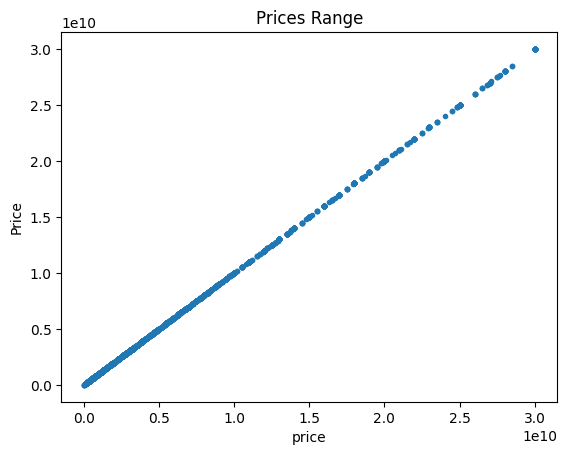

In [ ]:
plt.scatter(data['price'], data['price'], marker=".")
plt.xlabel('price')
plt.ylabel('Price')
plt.title('Prices Range')
plt.show()

# sns.set_style('whitegrid')
# sns.displot(data['price'], kde = True, color ='red', bins = 30)

8


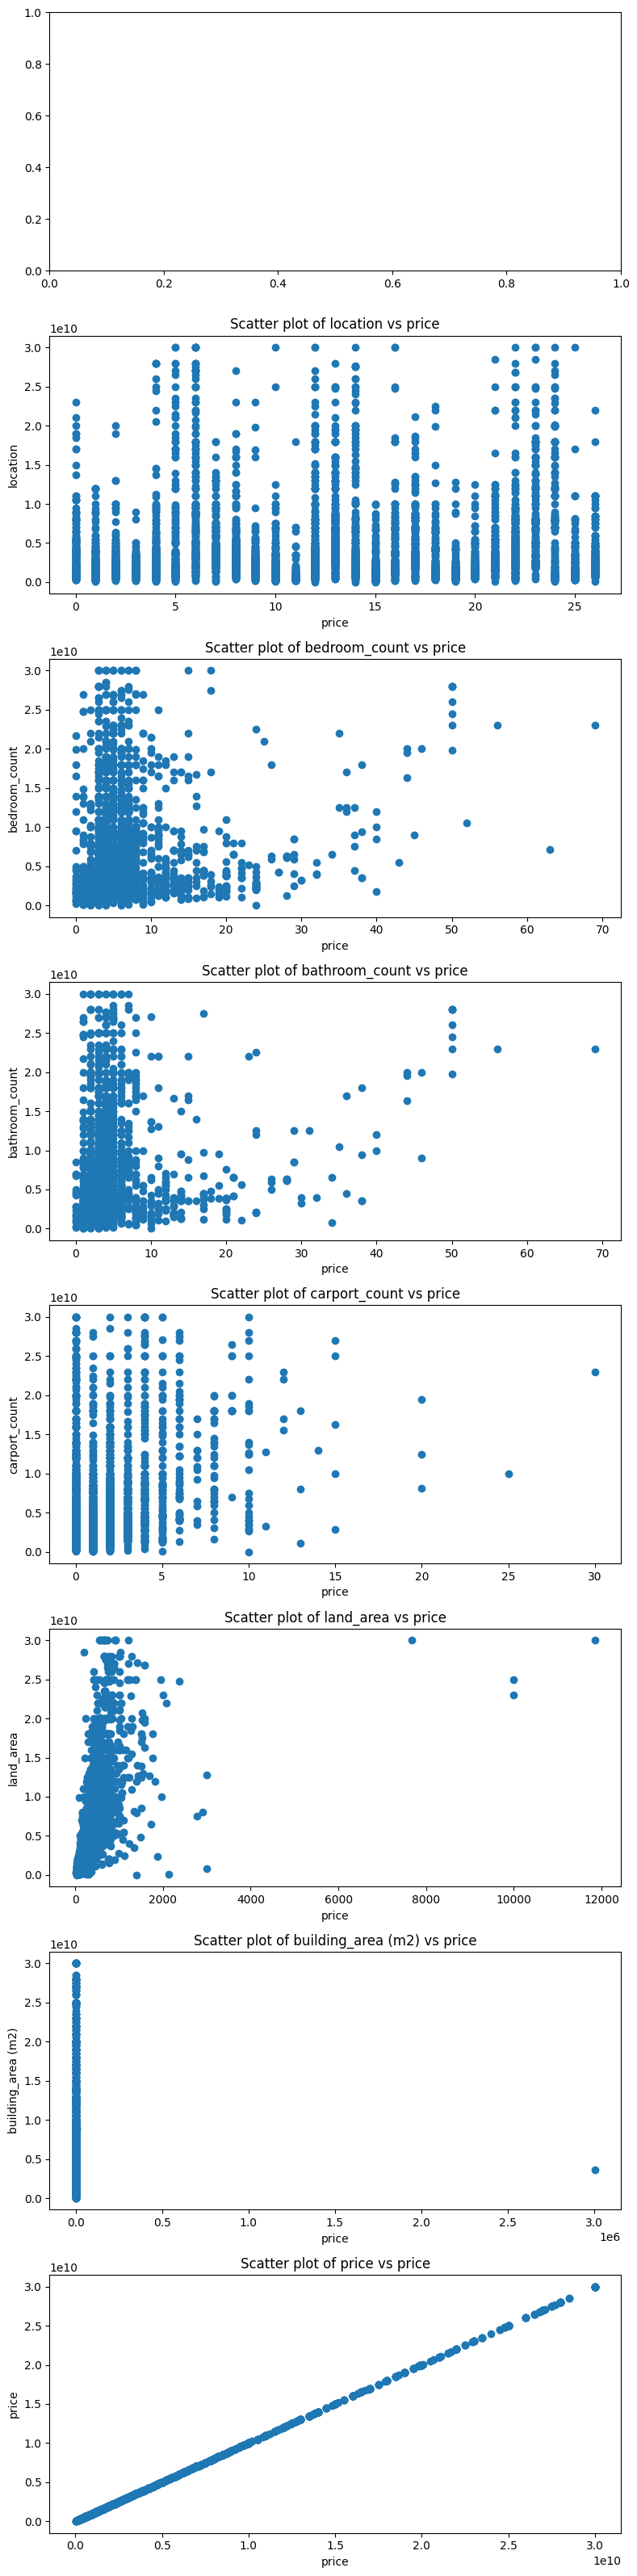

In [ ]:
num_features = data.shape[1]
data_plot = data
fig, axes = plt.subplots(num_features, 1, figsize=(8, 4 * num_features))

print(num_features)

le = LabelEncoder()

for i in range(num_features):
  feature_name = data_plot.columns[i]
  if feature_name != 'house_name':
    if feature_name == 'location':
      data_plot['location'] = le.fit_transform(data_plot['location'].sort_values(ascending=True))
    axes[i].scatter(data_plot.iloc[:, i], data_plot['price'], marker="o")
    axes[i].set_xlabel('price')
    axes[i].set_ylabel(feature_name)
    axes[i].set_title(f'Scatter plot of {feature_name} vs price')

plt.tight_layout()
plt.show()

In [ ]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'Andir, Bandung': 0,
 'Antapani, Bandung': 1,
 'Arcamanik, Bandung': 2,
 'Astanaanyar, Bandung': 3,
 'Babakanciparay, Bandung': 4,
 'Bandung Kidul, Bandung': 5,
 'Bandung Kulon, Bandung': 6,
 'Bandung Wetan, Bandung': 7,
 'Batununggal, Bandung': 8,
 'Bojongloa Kidul, Bandung': 9,
 'Buah Batu, Bandung': 10,
 'Cibeunying Kidul, Bandung': 11,
 'Cibiru, Bandung': 12,
 'Cicendo, Bandung': 13,
 'Cidadap, Bandung': 14,
 'Coblong, Bandung': 15,
 'Gede Bage, Bandung': 16,
 'Kiaracondong, Bandung': 17,
 'Lengkong, Bandung': 18,
 'Mandalajati, Bandung': 19,
 'Panyileukan, Bandung': 20,
 'Rancasari, Bandung': 21,
 'Regol, Bandung': 22,
 'Sukajadi, Bandung': 23,
 'Sukasari, Bandung': 24,
 'Sumurbandung, Bandung': 25,
 'Ujungberung, Bandung': 26}

In [ ]:
data.loc[:, 'price'].mean()

3885220788.144646

## One-hot the Dataset

In [ ]:
data_one_hot = pd.get_dummies(data.drop('house_name', axis=1), dtype=int)
data_one_hot

,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2),price
0,0,3,2,2,137,170,2100000000
1,0,3,2,3,202,300,4099999999
2,0,5,2,1,350,258,3300000000
3,0,2,2,1,30,80,580000000
4,0,11,3,0,176,176,1300000000
...,...,...,...,...,...,...,...
7605,4,3,2,0,110,90,780000000
7607,4,4,5,2,200,600,3200000000
7608,4,6,3,3,375,290,5500000000
7609,4,5,3,3,375,290,4890000000


In [ ]:
data

,house_name,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2),price
0,Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...,0,3,2,2,137,170,2100000000
1,Rumah Cantik @ Andir (Sudirman),0,3,2,3,202,300,4099999999
2,Jual Cepat Rumah di Maleber Rajawali Bisa Untu...,0,5,2,1,350,258,3300000000
3,Rumah minimalis 3 lantai di andir Bandung coco...,0,2,2,1,30,80,580000000
4,Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...,0,11,3,0,176,176,1300000000
...,...,...,...,...,...,...,...,...
7605,Rumah Bangunan Lama Kondisi Terawat di Ciboler...,4,3,2,0,110,90,780000000
7607,Rumah 3 Lantai Bagus Terawat di Sumber Sari,4,4,5,2,200,600,3200000000
7608,Rumah Besar Elegant Asri Nyaman Sumbersari Ban...,4,6,3,3,375,290,5500000000
7609,Rumah strategis nyaman belakang mall sumber sa...,4,5,3,3,375,290,4890000000


In [ ]:
X = data_one_hot.drop('price', axis=1)
y = data_one_hot['price']

X.head()

,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2)
0,0,3,2,2,137,170
1,0,3,2,3,202,300
2,0,5,2,1,350,258
3,0,2,2,1,30,80
4,0,11,3,0,176,176


## Data Plot & Data Describe

### Describe Data Comparison (Before & After Clean)

In [ ]:
print(data.describe())

          location  bedroom_count  bathroom_count  carport_count  \
count  6547.000000    6547.000000     6547.000000    6547.000000   
mean     12.188331       4.494730        3.194287       1.350695   
std       7.784945       4.390094        3.709075       1.673503   
min       0.000000       0.000000        0.000000       0.000000   
25%       5.000000       3.000000        2.000000       0.000000   
50%      12.000000       4.000000        3.000000       1.000000   
75%      19.000000       5.000000        3.000000       2.000000   
max      26.000000      69.000000       69.000000      30.000000   

          land_area  building_area (m2)         price  
count   6547.000000        6.547000e+03  6.547000e+03  
mean     248.073163        6.966942e+02  3.885221e+09  
std      334.571395        3.714861e+04  4.790822e+09  
min        6.000000        1.000000e+00  1.200000e+07  
25%      101.000000        1.000000e+02  1.100000e+09  
50%      162.000000        1.800000e+02  2.200000e+

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
len(X), len(X_train), len(X_test)

(6547, 5237, 1310)

In [ ]:
train_data = pd.DataFrame(data.drop(['house_name', 'price'], axis=1))
train_data['target'] = data['price']
train_data['location'] = LabelEncoder().fit_transform(train_data['location'])
train_data

,location,bedroom_count,bathroom_count,carport_count,land_area,building_area (m2),target
0,0,3,2,2,137,170,2100000000
1,0,3,2,3,202,300,4099999999
2,0,5,2,1,350,258,3300000000
3,0,2,2,1,30,80,580000000
4,0,11,3,0,176,176,1300000000
...,...,...,...,...,...,...,...
7605,4,3,2,0,110,90,780000000
7607,4,4,5,2,200,600,3200000000
7608,4,6,3,3,375,290,5500000000
7609,4,5,3,3,375,290,4890000000


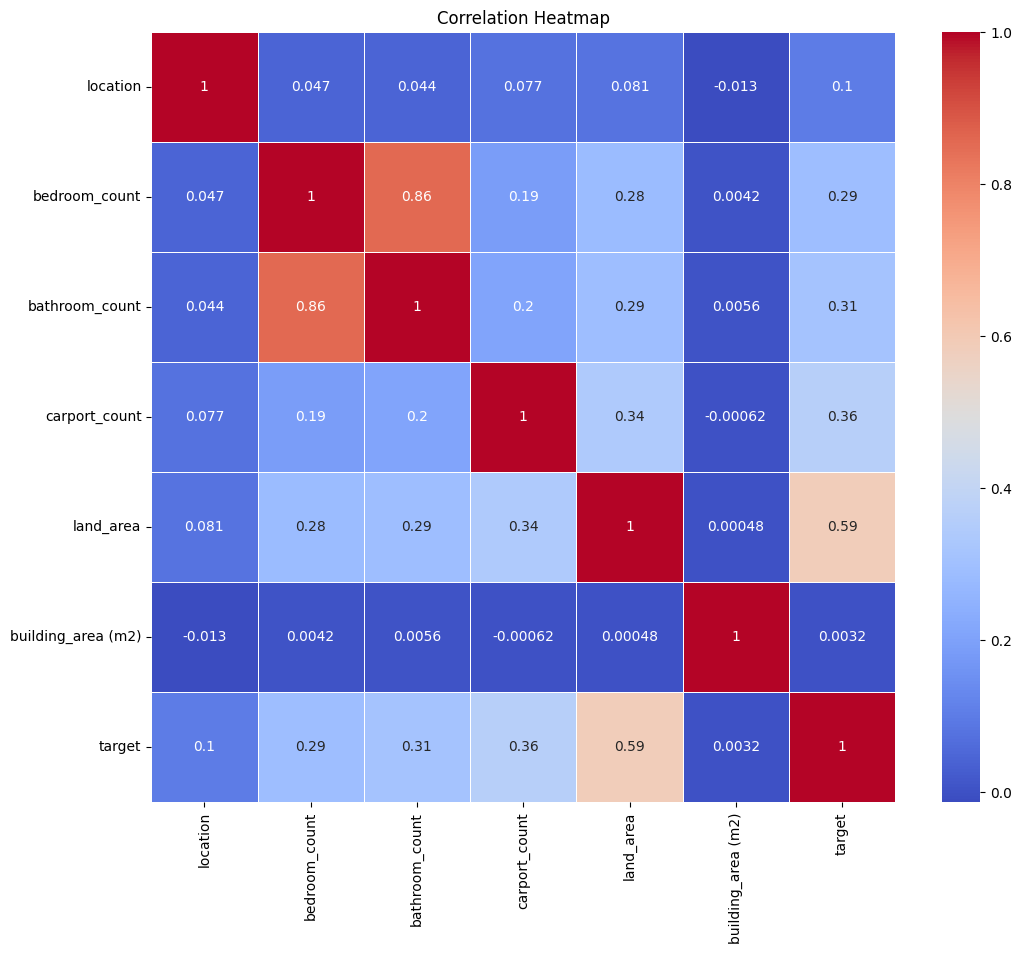

In [ ]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def plot_history(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history_dict['loss'], label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history_dict['mae'], label='Training MAE')
    plt.plot(epochs, history_dict['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

In [ ]:
def plot_result(y_preds, y_test, title="Scatter Plot with Trend Lines"):
  y_preds_normal_1d = np.ravel(y_preds)
  y_test_normal_1d = np.ravel(y_test)

  plt.figure(figsize=(20, 14))
  # plt.scatter(y_preds_normal_1d, y_test_normal_1d, c="r", label="Test data", marker="o")
  plt.scatter(y_test_normal_1d, y_preds_normal_1d, c="b", label="Predictions data", marker="o")

  # Fit line to the test data
  fit_test = np.polyfit(y_preds_normal_1d, y_test_normal_1d, 1)
  fit_line_test = np.poly1d(fit_test)

  # Fit line to the predictions data
  fit_pred = np.polyfit(y_test_normal_1d, y_preds_normal_1d, 1)
  fit_line_pred = np.poly1d(fit_pred)

  # Generate x-values for the trend line
  x_test = np.linspace(min(y_preds_normal_1d), max(y_preds_normal_1d), 100)

  # Plot trend lines
  plt.plot(x_test, fit_line_test(x_test), color="r", linestyle="-", linewidth=2, label="Test Data Trend line")
  # plt.plot(x_pred, fit_line_pred(x_pred), color="b", linestyle="-", linewidth=2, label="Trend line (Predictions data)")

  plt.legend()
  plt.xlabel("Predicted values")
  plt.ylabel("Actual values")
  plt.title(title)

  plt.show()

In [ ]:
def plot_stack_bar(train_results, val_results, metrics=['MSE', 'MAE', 'RMSE', 'R²']):
  # Sample data for metrics
  train_metrics = train_results
  val_metrics = val_results

  # Define the bar width
  width = 0.35

  # Define the position of bars on the x-axis
  x = np.arange(len(metrics))

  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the bars
  bar1 = ax.bar(x, train_metrics, width, label='Train')
  bar2 = ax.bar(x, val_metrics, width, bottom=train_metrics, label='Validation')

  # Adding labels and title
  ax.set_xlabel('Metrics')
  ax.set_ylabel('Scores')
  ax.set_title('Training vs Validation Metrics')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  # Function to add values on top of bars
  def add_values(bars):
      for bar in bars:
          height = bar.get_height()
          ax.annotate(f'{height:.2f}',
                      xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='center', fontsize=10, color='white')

  # Adding values on the bars
  add_values(bar1)
  add_values(bar2)

  plt.tight_layout()
  plt.show()

## Use Data Scaling, Data Split, & Normalization

In [ ]:
data_split_random = 60
val_size = 0.1

### 20/80 Data

In [ ]:
ct = make_column_transformer(
    (MinMaxScaler(feature_range=(0, 1)), ['bedroom_count', 'bathroom_count', 'carport_count', 'land_area', 'building_area (m2)', 'location'])
    # (OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["location"])
)

X = data.drop('price', axis=1)
y = data['price']

split_value = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_value, random_state=42)
ct.fit(X_train)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))

X_train_normal = ct.transform(X_train)
X_test_normal_full = ct.transform(X_test)

y_train_normal = scaler_y.transform(y_train.values.reshape(-1, 1))
y_test_normal_full = scaler_y.transform(y_test.values.reshape(-1, 1))

X_test_normal, X_val_normal, y_test_normal, y_val_normal = train_test_split(X_test_normal_full, y_test_normal_full, test_size=0.5, random_state=42)

In [ ]:
scaler = ct.named_transformers_['minmaxscaler']

# Save the MinMaxScaler to a file
with open('scaler_x.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [ ]:
X_train_normal.shape, X_test_normal.shape, X_val_normal.shape

((5237, 6), (655, 6), (655, 6))

In [ ]:
print(y_test_normal)

[[0.63318661]
 [0.02961184]
 [0.04628518]
 [0.05295452]
 [0.05462185]
 [0.05528878]
 [0.04128318]
 [0.02210884]
 [0.10630919]
 [0.04461785]
 [0.31639322]
 [0.53314659]
 [0.02234227]
 [0.03528078]
 [0.33306656]
 [0.07129518]
 [0.18300654]
 [0.09963986]
 [0.01623983]
 [0.36641323]
 [0.04961985]
 [0.08296652]
 [0.23302654]
 [0.04861945]
 [0.09963986]
 [0.01794051]
 [0.11297852]
 [0.02460984]
 [0.08296652]
 [0.03127918]
 [0.01920768]
 [0.07462985]
 [0.02877818]
 [0.05628918]
 [0.08296652]
 [0.11631319]
 [0.00877017]
 [0.04961985]
 [0.03961585]
 [0.21635321]
 [0.18300654]
 [0.06962785]
 [0.02961184]
 [0.04961985]
 [0.06962785]
 [0.06962785]
 [0.33973589]
 [0.07296252]
 [0.23302654]
 [0.01794051]
 [0.1663332 ]
 [0.06295852]
 [0.08630119]
 [0.05628918]
 [0.05295452]
 [0.04961985]
 [0.04628518]
 [0.07462985]
 [0.16466587]
 [0.14965986]
 [0.02294251]
 [0.04128318]
 [0.11631319]
 [0.03077898]
 [0.01734027]
 [0.08063225]
 [0.41643324]
 [0.02794451]
 [0.13965586]
 [0.17466987]
 [0.59983994]
 [0.14

In [ ]:
print(X_train_normal)
print(type(X_test_normal))

[[2.89855072e-02 1.44927536e-02 0.00000000e+00 7.61163735e-04
  2.06254227e-05 1.15384615e-01]
 [7.24637681e-02 4.34782609e-02 3.33333333e-02 2.47801083e-02
  1.24417872e-04 1.92307692e-01]
 [4.34782609e-02 2.89855072e-02 0.00000000e+00 2.87550744e-03
  3.22688065e-05 6.15384615e-01]
 ...
 [4.34782609e-02 2.89855072e-02 0.00000000e+00 2.87550744e-03
  1.63007373e-05 8.07692308e-01]
 [4.34782609e-02 2.89855072e-02 1.33333333e-01 1.64918809e-02
  6.62009535e-05 8.46153846e-01]
 [5.79710145e-02 4.34782609e-02 6.66666667e-02 7.94993234e-03
  3.62608238e-05 7.69230769e-02]]
<class 'numpy.ndarray'>


### 30/70 Data

In [ ]:
split_value = 0.3

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=split_value, random_state=42)

ct.fit(X_train_1)

scaler_y_1 = MinMaxScaler()
scaler_y_1.fit(y_train_1.values.reshape(-1, 1))

X_train_normal_1 = ct.transform(X_train_1)
X_test_normal_full_1 = ct.transform(X_test_1)

y_train_normal_1 = scaler_y_1.transform(y_train_1.values.reshape(-1, 1))
y_test_normal_full_1 = scaler_y_1.transform(y_test_1.values.reshape(-1, 1))

X_test_normal_1, X_val_normal_1, y_test_normal_1, y_val_normal_1 = train_test_split(X_test_normal_full_1, y_test_normal_full_1, test_size=0.5, random_state=data_split_random)

In [ ]:
X_train_1.shape, X_test_normal_1.shape, X_val_normal_1.shape

((4582, 7), (982, 6), (983, 6))

In [ ]:
print(X_train_normal)
print(type(X_test_normal))

[[2.89855072e-02 1.44927536e-02 0.00000000e+00 7.61163735e-04
  2.06254227e-05 1.15384615e-01]
 [7.24637681e-02 4.34782609e-02 3.33333333e-02 2.47801083e-02
  1.24417872e-04 1.92307692e-01]
 [4.34782609e-02 2.89855072e-02 0.00000000e+00 2.87550744e-03
  3.22688065e-05 6.15384615e-01]
 ...
 [4.34782609e-02 2.89855072e-02 0.00000000e+00 2.87550744e-03
  1.63007373e-05 8.07692308e-01]
 [4.34782609e-02 2.89855072e-02 1.33333333e-01 1.64918809e-02
  6.62009535e-05 8.46153846e-01]
 [5.79710145e-02 4.34782609e-02 6.66666667e-02 7.94993234e-03
  3.62608238e-05 7.69230769e-02]]
<class 'numpy.ndarray'>


### 40/60 Data

In [ ]:
split_value = 0.4

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=split_value, random_state=42)

ct.fit(X_train_2)

scaler_y_2 = MinMaxScaler()
scaler_y_2.fit(y_train_2.values.reshape(-1, 1))

X_train_normal_2 = ct.transform(X_train_2)
X_test_normal_full_2 = ct.transform(X_test_2)

y_train_normal_2 = scaler_y_2.transform(y_train_2.values.reshape(-1, 1))
y_test_normal_full_2 = scaler_y_2.transform(y_test_2.values.reshape(-1, 1))

X_test_normal_2, X_val_normal_2, y_test_normal_2, y_val_normal_2 = train_test_split(X_test_normal_full_2, y_test_normal_full_2, test_size=0.5, random_state=data_split_random)

In [ ]:
X_train_2.shape, X_test_normal_2.shape, X_val_normal_2.shape

((3928, 7), (1309, 6), (1310, 6))

### 50/50 Data

In [ ]:
split_value = 0.5

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=split_value, random_state=42)

ct.fit(X_train_3)

scaler_y_3 = MinMaxScaler()
scaler_y_3.fit(y_train_3.values.reshape(-1, 1))

X_train_normal_3 = ct.transform(X_train_3)
X_test_normal_full_3 = ct.transform(X_test_3)

y_train_normal_3 = scaler_y_3.transform(y_train_3.values.reshape(-1, 1))
y_test_normal_full_3 = scaler_y_3.transform(y_test_3.values.reshape(-1, 1))

X_test_normal_3, X_val_normal_3, y_test_normal_3, y_val_normal_3 = train_test_split(X_test_normal_full_3, y_test_normal_full_3, test_size=0.5, random_state=data_split_random)

In [ ]:
X_train_3.shape, X_test_normal_3.shape, X_val_normal_3.shape

((3273, 7), (1637, 6), (1637, 6))

## Create the models

### Check a suitable learning rate


In [ ]:
# tf.random.set_seed(60)

# house_price_check_model = tf.keras.Sequential([
#     tf.keras.layers.Dense(100),
#     tf.keras.layers.Dense(100),
#     tf.keras.layers.Dense(50),
#     tf.keras.layers.Dense(1)
# ])


# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# def root_mean_squared_error_loss(y_true, y_pred):
#     return tf.keras.backend.sqrt(tf.keras.losses.MSE(y_true, y_pred))

# def r_square_loss(y_true, y_pred):
#     return 1 - tf.keras.backend.sum((y_true - y_pred) ** 2) / tf.keras.backend.sum((y_true - tf.keras.backend.mean(y_true)) ** 2)

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# house_price_check_model.compile(loss=tf.keras.losses.MAE,
#                           optimizer="Adam")

# # lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# history_lr_check = house_price_check_model.fit(X_train_normal,
#                                 y_train_normal,
#                                 epochs=75,
#                                 callbacks=[lr_scheduler],
#                                 validation_data=(X_val_normal, y_val_normal),
#                                 verbose=1)
# house_price_check_model.evaluate(X_test_normal, y_test_normal)

In [ ]:
# pd.DataFrame(history_lr_check.history).plot(figsize=(10, 7), xlabel="epochs")

## Hyperparameter Tuning

In [ ]:
model_metrics = [
    "mae",
    "mse",
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    tf.keras.metrics.R2Score(name='r2')
  ]

tuner_exist = False

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

class HousePriceHyperModel(HyperModel):
    def __init__(self, model_name="default_model", dropout=False):
        self.model_name = model_name
        self.dropout = dropout

    def build(self, hp, model_name=None, dropout=False):
        if model_name is None:
            model_name = self.model_name

        model = tf.keras.Sequential(name=model_name)

        # Tune the number of layers
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(tf.keras.layers.Dense(
                units=hp.Int('units_' + str(i), min_value=50, max_value=360, step=50),
                activation=hp.Choice('activation_' + str(i), ['relu', 'tanh'])
            ))

            if self.dropout:
              model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

        model.add(tf.keras.layers.Dense(1))

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
            ),
            loss=tf.keras.losses.mae,
            metrics=['mae', 'mse', rmse]
        )

        return model

hypermodel = HousePriceHyperModel()

In [ ]:
tuner = GridSearch(
    hypermodel,
    objective=Objective('val_rmse', direction='min'),  # Objective to minimize
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train with each combination of hyperparameters
    seed=42,
    # directory='my_dir',  # Directory to save logs and checkpoints
    project_name='house_price_tuning'
)

Reloading Tuner from ./house_price_tuning/tuner0.json


In [ ]:
# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',
    patience=10,
    restore_best_weights=True
)

# Split your data into training and validation sets
X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(X_train_normal, y_train_normal, test_size=0.2)

# Perform the search
tuner.search(
    X_train_hp, y_train_hp,
    epochs=50,  # Number of epochs for each trial
    validation_data=(X_val_hp, y_val_hp),
    callbacks=[early_stopping]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps)

print(best_hps.get('num_layers'))
print(best_hps.get('units_0'))
print(best_hps.get('learning_rate'))
print(best_hps.get('activation_0'))

num_layers = best_hps.get('num_layers')
activation_functions = [best_hps.get(f'activation_{i}') for i in range(num_layers)]
print(f'Activation functions used in the best model: {activation_functions}')

best_learning_rate = best_hps.get('learning_rate')
print(f'Best learning rate: {best_learning_rate}')

1
50
0.0050118723362727255
relu
Activation functions used in the best model: ['relu']
Best learning rate: 0.0050118723362727255


In [ ]:
# if tuner_exist is False:
#   shutil.make_archive("house_price_tuning", 'zip', "house_price_tuning")
#   files.download("house_price_tuning.zip")

#   tuner_exist = True

## Compare against Data Ratio (With Dropout)


### Test & train ratio (20/80)

In [ ]:
tf.random.set_seed(60)
np.random.seed(60)

house_price_model = tuner.hypermodel.build(best_hps, model_name='model_20/80_ratio', dropout=True)

house_price_model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.000316227766016838),
                          metrics=model_metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='rmse',
    patience=10,
    restore_best_weights=True
)

history_normalized = house_price_model.fit(X_train_normal,
                                y_train_normal,
                                epochs=500,
                                callbacks=[early_stopping],
                                validation_data=(X_val_normal, y_val_normal),
                                verbose=1)
history_normalized_result = house_price_model.evaluate(X_test_normal, y_test_normal)

Epoch 1/500
164/164 [==============================] - 2s 6ms/step - loss: 0.0915 - mae: 0.0915 - mse: 0.0277 - rmse: 0.1536 - r2: 0.0821 - val_loss: 0.0797 - val_mae: 0.0797 - val_mse: 0.0244 - val_rmse: 0.1562 - val_r2: 0.0619
Epoch 2/500
164/164 [==============================] - 1s 4ms/step - loss: 0.0789 - mae: 0.0789 - mse: 0.0226 - rmse: 0.1502 - r2: 0.1111 - val_loss: 0.0737 - val_mae: 0.0737 - val_mse: 0.0210 - val_rmse: 0.1451 - val_r2: 0.1908
Epoch 3/500
164/164 [==============================] - 0s 3ms/step - loss: 0.0736 - mae: 0.0736 - mse: 0.0203 - rmse: 0.1424 - r2: 0.2011 - val_loss: 0.0689 - val_mae: 0.0689 - val_mse: 0.0194 - val_rmse: 0.1391 - val_r2: 0.2555
Epoch 4/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0699 - mae: 0.0699 - mse: 0.0187 - rmse: 0.1366 - r2: 0.2653 - val_loss: 0.0667 - val_mae: 0.0667 - val_mse: 0.0181 - val_rmse: 0.1344 - val_r2: 0.3052
Epoch 5/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0675 - 

In [ ]:
house_price_model.summary()

Model: "model_20/80_ratio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                350       
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: xlabel='epochs'>

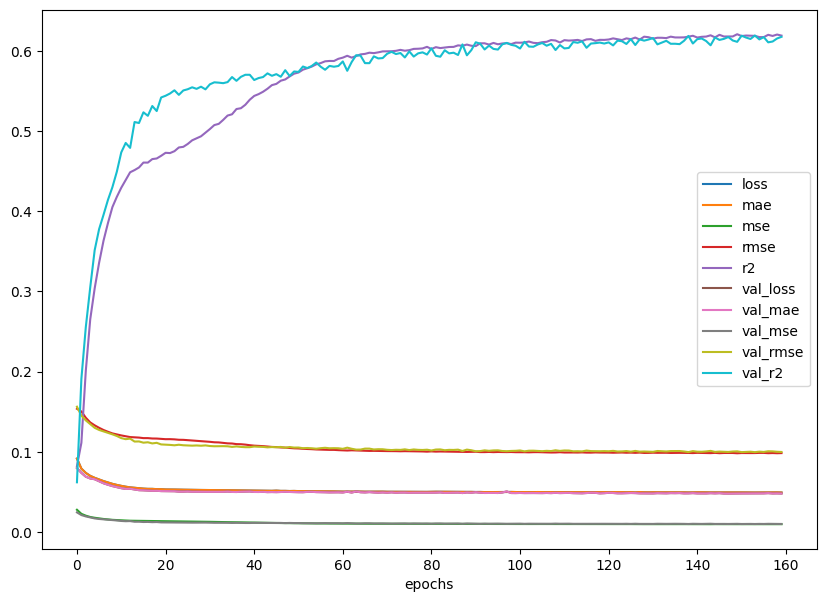

In [ ]:
pd.DataFrame(history_normalized.history).plot(figsize=(10, 7), xlabel="epochs")

#### Plot Each Metrics

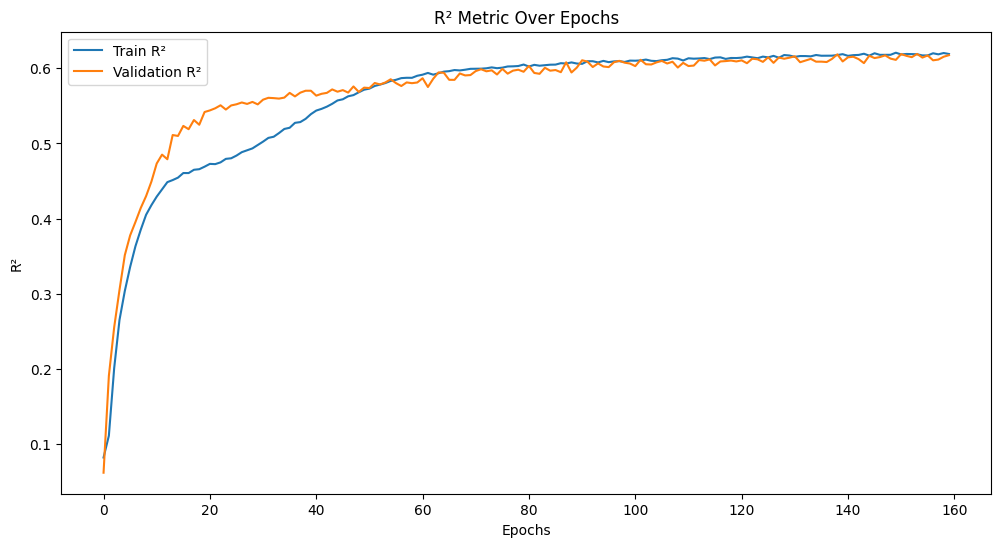

In [ ]:
history_df = pd.DataFrame(history_normalized.history)

# Plot R²
plt.figure(figsize=(12, 6))
plt.plot(history_df['r2'], label='Train R²')

plt.plot(history_df['val_r2'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('R² Metric Over Epochs')
plt.legend()
plt.show()


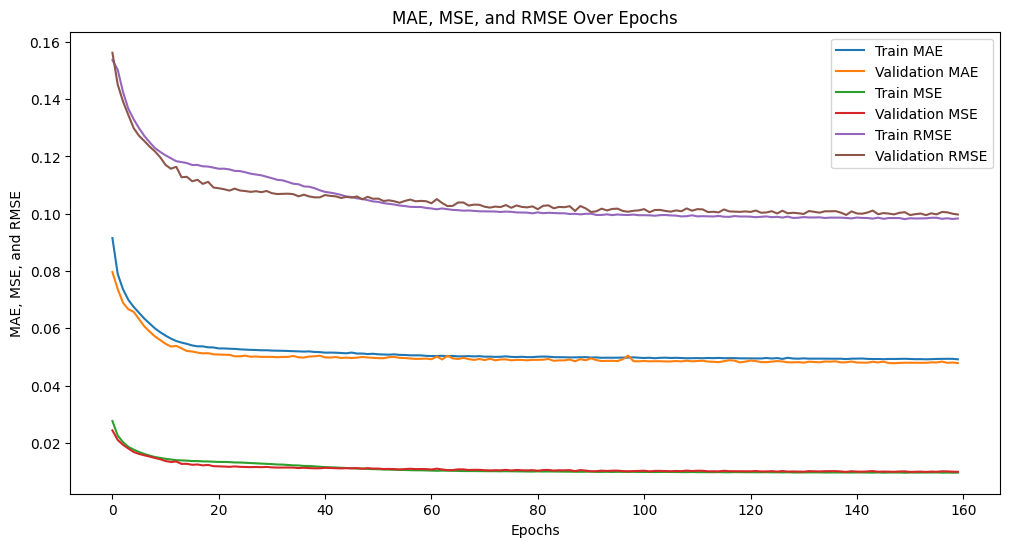

In [ ]:
# Plot MAE, MSE, and RMSE
plt.figure(figsize=(12, 6))
plt.plot(history_df['mae'], label='Train MAE')
plt.plot(history_df['val_mae'], label='Validation MAE')
plt.plot(history_df['mse'], label='Train MSE')
plt.plot(history_df['val_mse'], label='Validation MSE')
plt.plot(history_df['rmse'], label='Train RMSE')
plt.plot(history_df['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('MAE, MSE, and RMSE')
plt.title('MAE, MSE, and RMSE Over Epochs')
plt.legend()
plt.show()

In [ ]:
y_preds_normal = house_price_model.predict(X_test_normal.astype('float'))

21/21 [==============================] - 0s 2ms/step


In [ ]:
y_preds_normal.shape, y_test_normal.shape

((655, 1), (655, 1))

#### Results

In [ ]:
df_result_data = {
    'y_test': y_test_normal.squeeze(),
    'y_preds': y_preds_normal.squeeze(),
    'diff': y_test_normal.squeeze() - y_preds_normal.squeeze()
}

df_result = pd.DataFrame(df_result_data)
df_result.head()

,y_test,y_preds,diff
0,0.633187,0.237783,0.395403
1,0.029612,0.035719,-0.006108
2,0.046285,0.065818,-0.019532
3,0.052955,0.023946,0.029008
4,0.054622,0.031021,0.023601


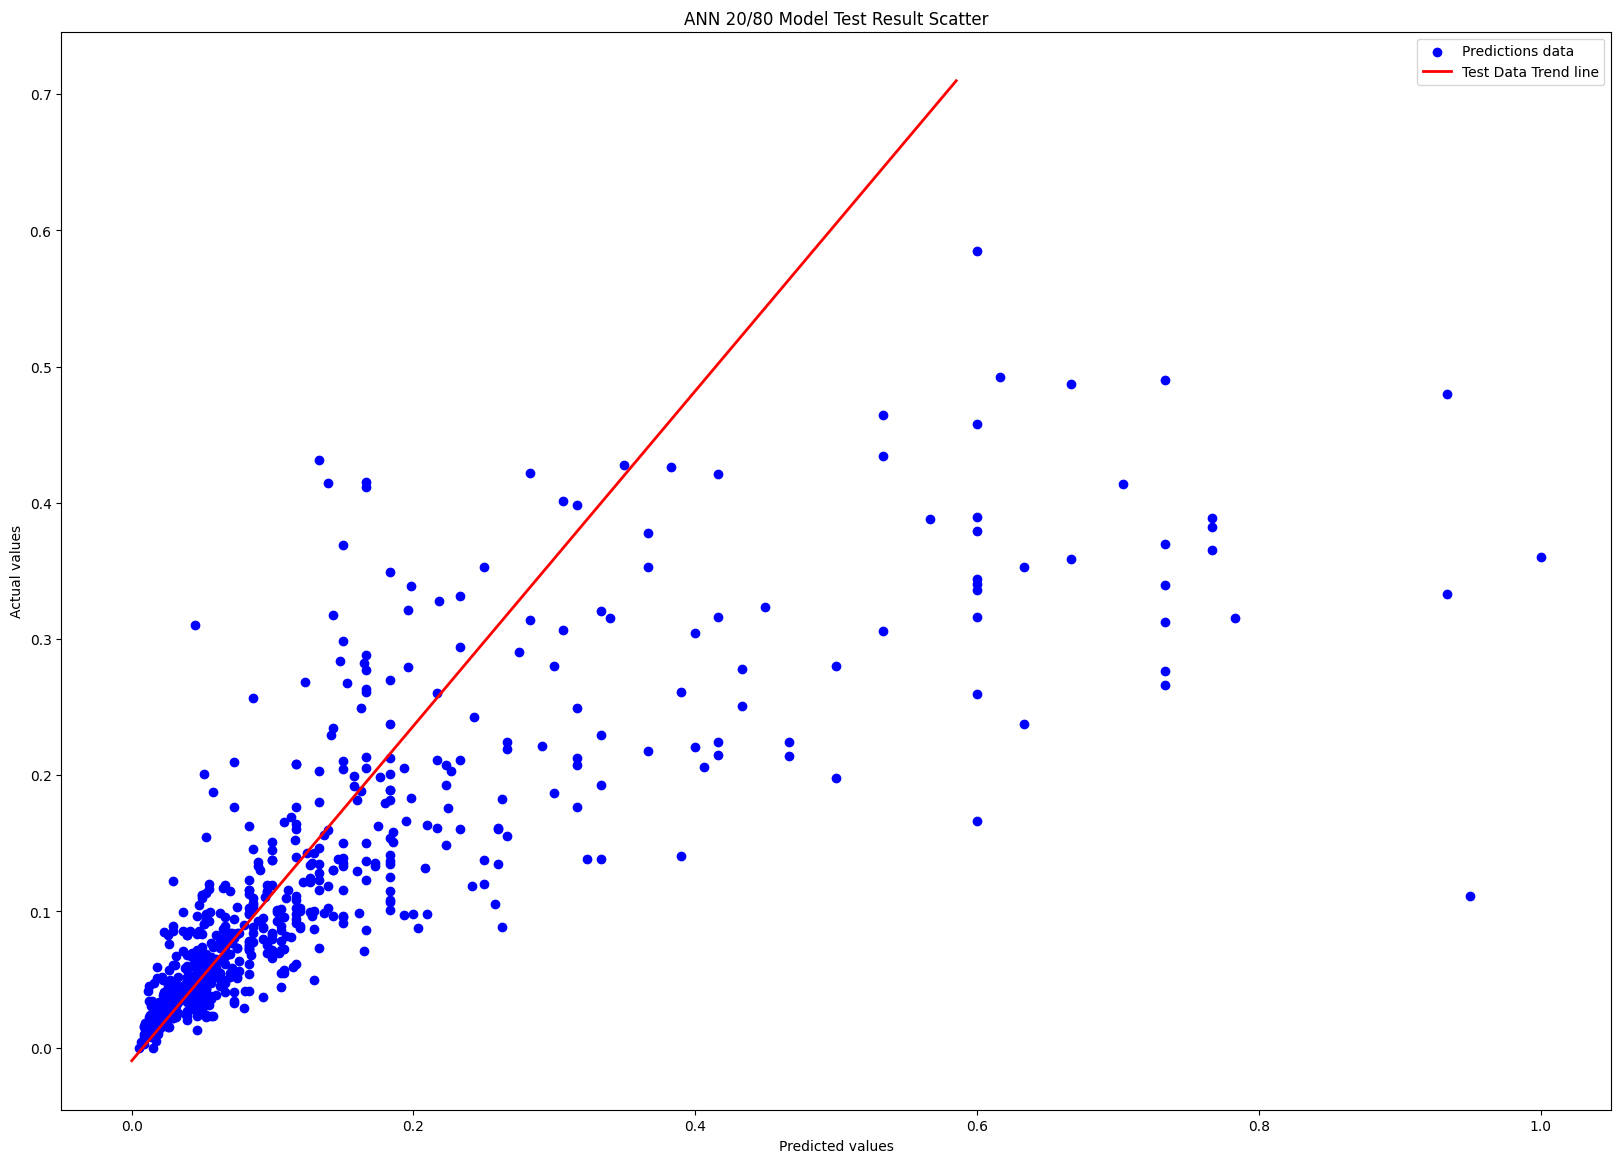

In [ ]:
plot_result(y_preds_normal, y_test_normal, title="ANN 20/80 Model Test Result Scatter")

### Test & train ratio (30/70)

In [ ]:
tf.random.set_seed(60)
np.random.seed(60)

house_price_model_1 = tuner.hypermodel.build(best_hps, model_name='model_30/70_ratio', dropout=True)

house_price_model_1.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.000316227766016838),
                          metrics=model_metrics)

history_normalized_1 = house_price_model_1.fit(X_train_normal_1,
                                y_train_normal_1,
                                epochs=500,
                                callbacks=[early_stopping],
                                validation_data=(X_val_normal_1, y_val_normal_1),
                                verbose=1)
history_normalized_result_1 = house_price_model_1.evaluate(X_test_normal_1, y_test_normal_1)

Epoch 1/500
144/144 [==============================] - 2s 5ms/step - loss: 0.1033 - mae: 0.1033 - mse: 0.0325 - rmse: 0.1723 - r2: -0.1763 - val_loss: 0.0849 - val_mae: 0.0849 - val_mse: 0.0267 - val_rmse: 0.1634 - val_r2: -0.0196
Epoch 2/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0850 - mae: 0.0850 - mse: 0.0255 - rmse: 0.1597 - r2: -0.0147 - val_loss: 0.0792 - val_mae: 0.0792 - val_mse: 0.0242 - val_rmse: 0.1556 - val_r2: 0.0757
Epoch 3/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0804 - mae: 0.0804 - mse: 0.0236 - rmse: 0.1537 - r2: 0.0601 - val_loss: 0.0746 - val_mae: 0.0746 - val_mse: 0.0226 - val_rmse: 0.1503 - val_r2: 0.1375
Epoch 4/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.0767 - mse: 0.0218 - rmse: 0.1477 - r2: 0.1314 - val_loss: 0.0713 - val_mae: 0.0713 - val_mse: 0.0210 - val_rmse: 0.1448 - val_r2: 0.1990
Epoch 5/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0734

In [ ]:
house_price_model_1.summary()

Model: "model_30/70_ratio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                350       
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Plot Each Metrics

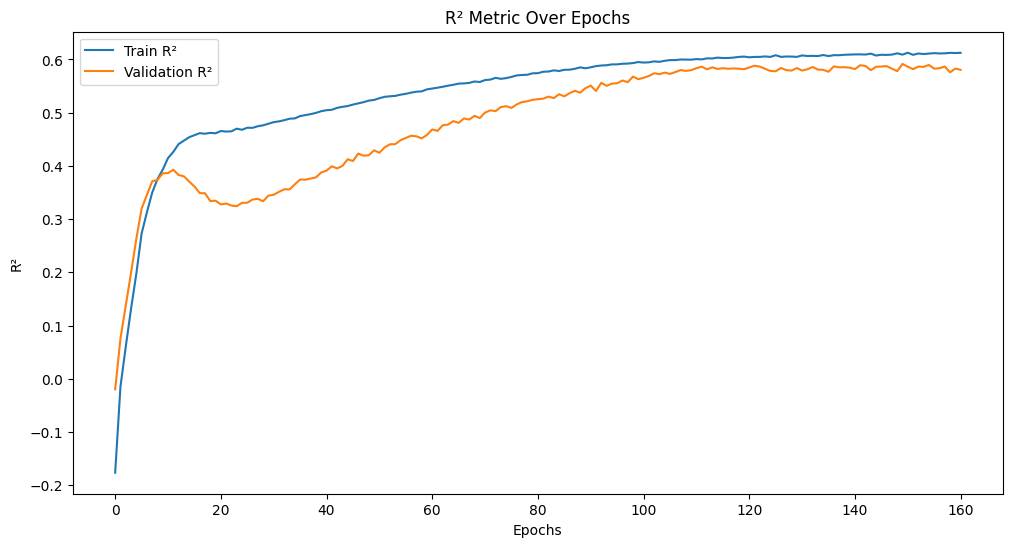

In [ ]:
history_df_1 = pd.DataFrame(history_normalized_1.history)

# Plot R²
plt.figure(figsize=(12, 6))
plt.plot(history_df_1['r2'], label='Train R²')

plt.plot(history_df_1['val_r2'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('R² Metric Over Epochs')
plt.legend()
plt.show()


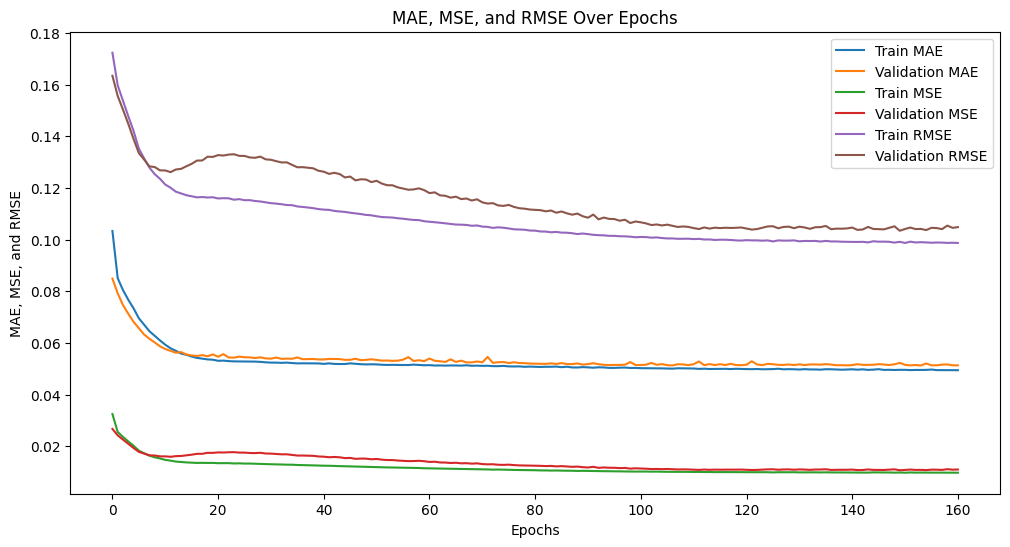

In [ ]:
# Plot MAE, MSE, and RMSE
plt.figure(figsize=(12, 6))
plt.plot(history_df_1['mae'], label='Train MAE')
plt.plot(history_df_1['val_mae'], label='Validation MAE')
plt.plot(history_df_1['mse'], label='Train MSE')
plt.plot(history_df_1['val_mse'], label='Validation MSE')
plt.plot(history_df_1['rmse'], label='Train RMSE')
plt.plot(history_df_1['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('MAE, MSE, and RMSE')
plt.title('MAE, MSE, and RMSE Over Epochs')
plt.legend()
plt.show()

<Axes: xlabel='epochs'>

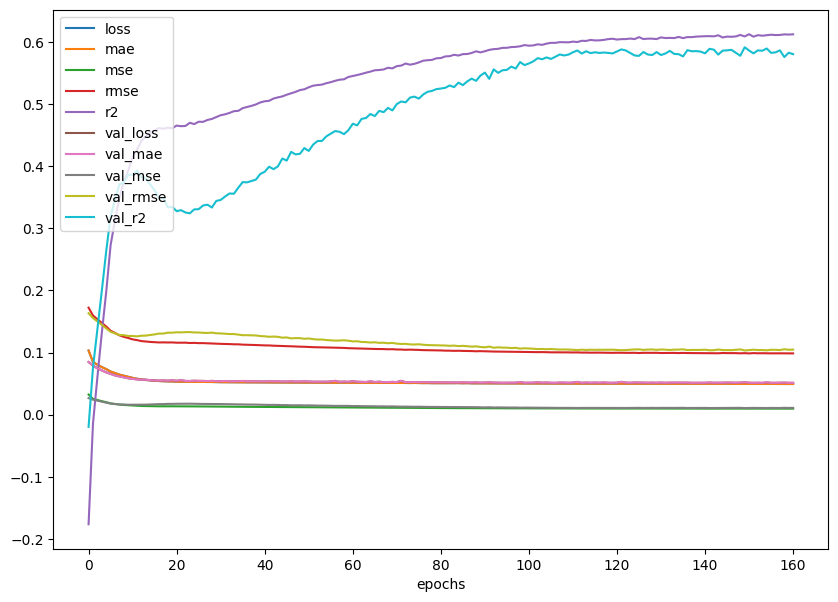

In [ ]:
pd.DataFrame(history_normalized_1.history).plot(figsize=(10, 7), xlabel="epochs")

#### Results

In [ ]:
y_preds_normal_1 = house_price_model_1.predict(X_test_normal_1.astype('float'))

31/31 [==============================] - 0s 2ms/step


In [ ]:
df_result_data_1 = {
    'y_test': y_test_normal_1.squeeze(),
    'y_preds': y_preds_normal_1.squeeze(),
    'diff': y_test_normal_1.squeeze() - y_preds_normal_1.squeeze()
}

df_result_1 = pd.DataFrame(df_result_data_1)
df_result_1.head()

,y_test,y_preds,diff
0,0.663199,0.360087,0.303112
1,0.082967,0.066425,0.016542
2,0.066293,0.059661,0.006632
3,0.069628,0.094003,-0.024375
4,0.054622,0.098333,-0.043711


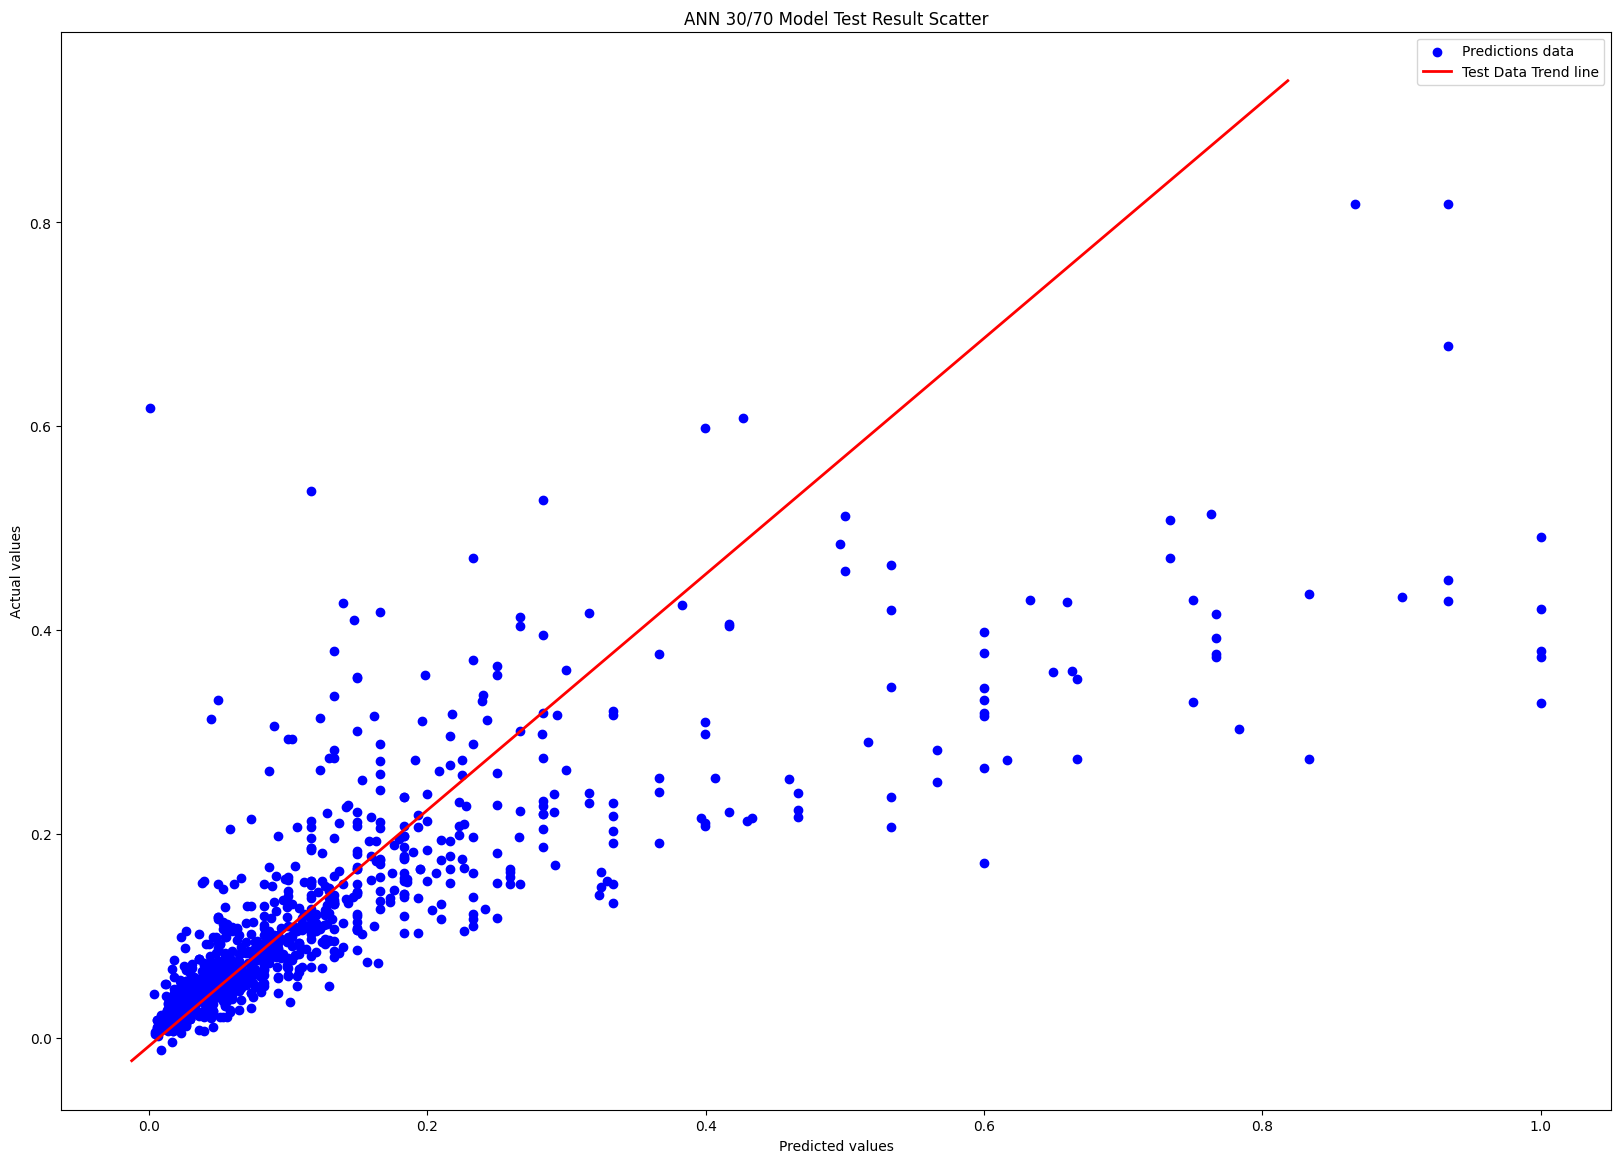

In [ ]:
plot_result(y_preds_normal_1, y_test_normal_1, title="ANN 30/70 Model Test Result Scatter")

### Test & train ratio (40/60)

In [ ]:
tf.random.set_seed(60)

house_price_model_2 = tuner.hypermodel.build(best_hps, model_name='model_40/60_ratio', dropout=True)

house_price_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.000316227766016838),
                          metrics=model_metrics)

history_normalized_2 = house_price_model_2.fit(X_train_normal_2,
                                y_train_normal_2,
                                epochs=500,
                                callbacks=[early_stopping],
                                validation_data=(X_val_normal_2, y_val_normal_2),
                                verbose=1)
history_normalized_result_2 = house_price_model_2.evaluate(X_test_normal_2, y_test_normal_2)

Epoch 1/500
123/123 [==============================] - 1s 4ms/step - loss: 0.1046 - mae: 0.1046 - mse: 0.0337 - rmse: 0.1701 - r2: -0.1258 - val_loss: 0.0882 - val_mae: 0.0882 - val_mse: 0.0264 - val_rmse: 0.1626 - val_r2: -0.0985
Epoch 2/500
123/123 [==============================] - 0s 2ms/step - loss: 0.0868 - mae: 0.0868 - mse: 0.0264 - rmse: 0.1626 - r2: -0.0381 - val_loss: 0.0783 - val_mae: 0.0783 - val_mse: 0.0220 - val_rmse: 0.1484 - val_r2: 0.0847
Epoch 3/500
123/123 [==============================] - 0s 3ms/step - loss: 0.0785 - mae: 0.0785 - mse: 0.0230 - rmse: 0.1516 - r2: 0.0980 - val_loss: 0.0711 - val_mae: 0.0711 - val_mse: 0.0191 - val_rmse: 0.1383 - val_r2: 0.2054
Epoch 4/500
123/123 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.0731 - mse: 0.0204 - rmse: 0.1429 - r2: 0.1981 - val_loss: 0.0675 - val_mae: 0.0675 - val_mse: 0.0181 - val_rmse: 0.1344 - val_r2: 0.2493
Epoch 5/500
123/123 [==============================] - 0s 2ms/step - loss: 0.0698

In [ ]:
house_price_model_2.summary()

Model: "model_40/60_ratio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                350       
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Plot Each Metrics

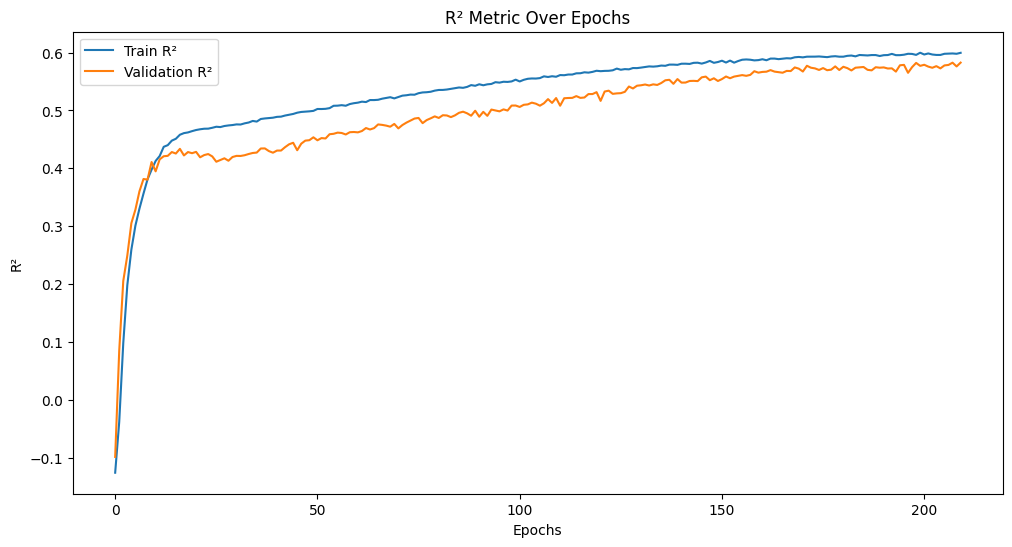

In [ ]:
history_df_2 = pd.DataFrame(history_normalized_2.history)

# Plot R²
plt.figure(figsize=(12, 6))
plt.plot(history_df_2['r2'], label='Train R²')

plt.plot(history_df_2['val_r2'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('R² Metric Over Epochs')
plt.legend()
plt.show()


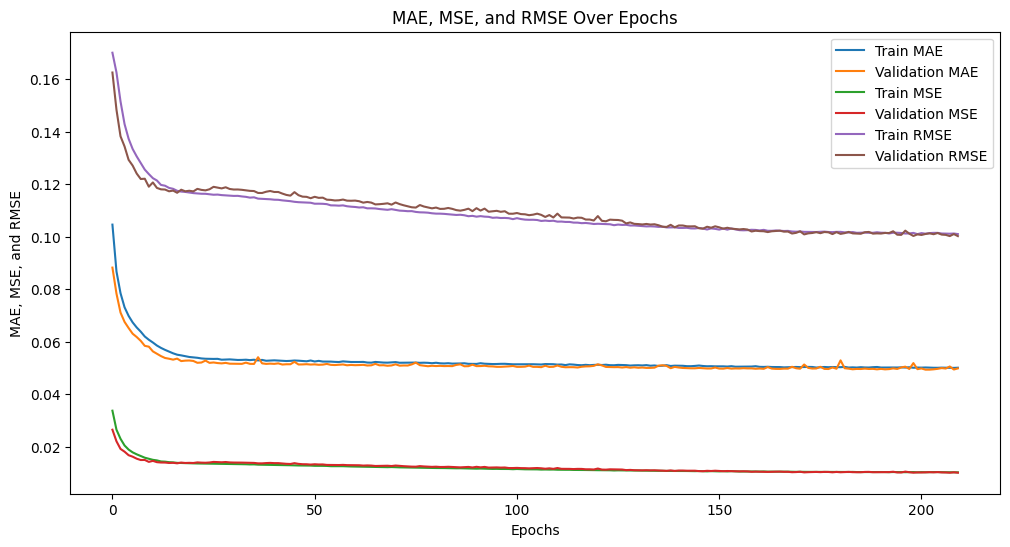

In [ ]:
# Plot MAE, MSE, and RMSE
plt.figure(figsize=(12, 6))
plt.plot(history_df_2['mae'], label='Train MAE')
plt.plot(history_df_2['val_mae'], label='Validation MAE')
plt.plot(history_df_2['mse'], label='Train MSE')
plt.plot(history_df_2['val_mse'], label='Validation MSE')
plt.plot(history_df_2['rmse'], label='Train RMSE')
plt.plot(history_df_2['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('MAE, MSE, and RMSE')
plt.title('MAE, MSE, and RMSE Over Epochs')
plt.legend()
plt.show()

<Axes: xlabel='epochs'>

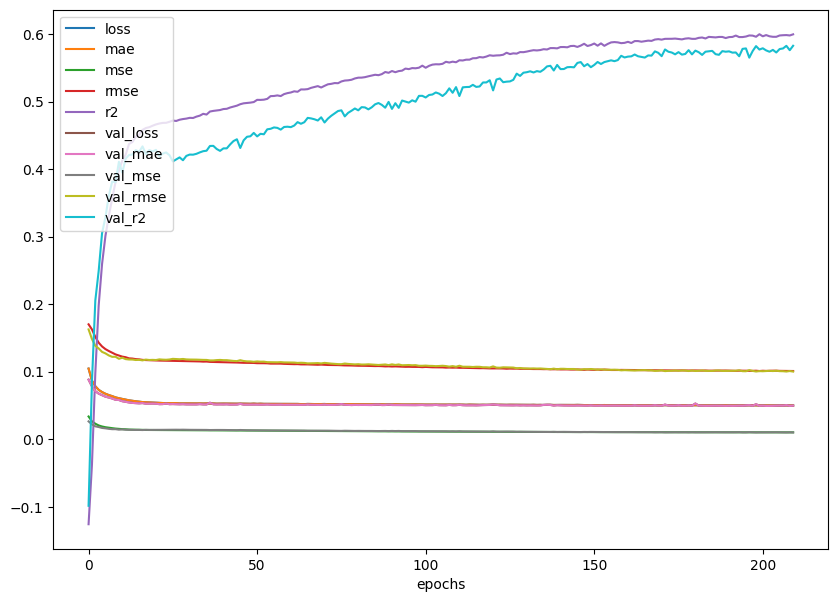

In [ ]:
pd.DataFrame(history_normalized_2.history).plot(figsize=(10, 7), xlabel="epochs")

#### Results

In [ ]:
y_preds_normal_2 = house_price_model_2.predict(X_test_normal_2.astype('float'))

41/41 [==============================] - 0s 1ms/step


In [ ]:
df_result_data_2 = {
    'y_test': y_test_normal_2.squeeze(),
    'y_preds': y_preds_normal_2.squeeze(),
    'diff': y_test_normal_2.squeeze() - y_preds_normal_2.squeeze()
}

df_result_2 = pd.DataFrame(df_result_data_2)
df_result_2.head()

,y_test,y_preds,diff
0,0.069628,0.066565,0.003063
1,0.333067,0.121193,0.211873
2,0.022109,0.028763,-0.006655
3,0.013772,0.019367,-0.005595
4,0.162665,0.183348,-0.020683


In [ ]:
y_preds_normal_2 = house_price_model_2.predict(X_test_normal_2.astype('float'))

41/41 [==============================] - 0s 1ms/step


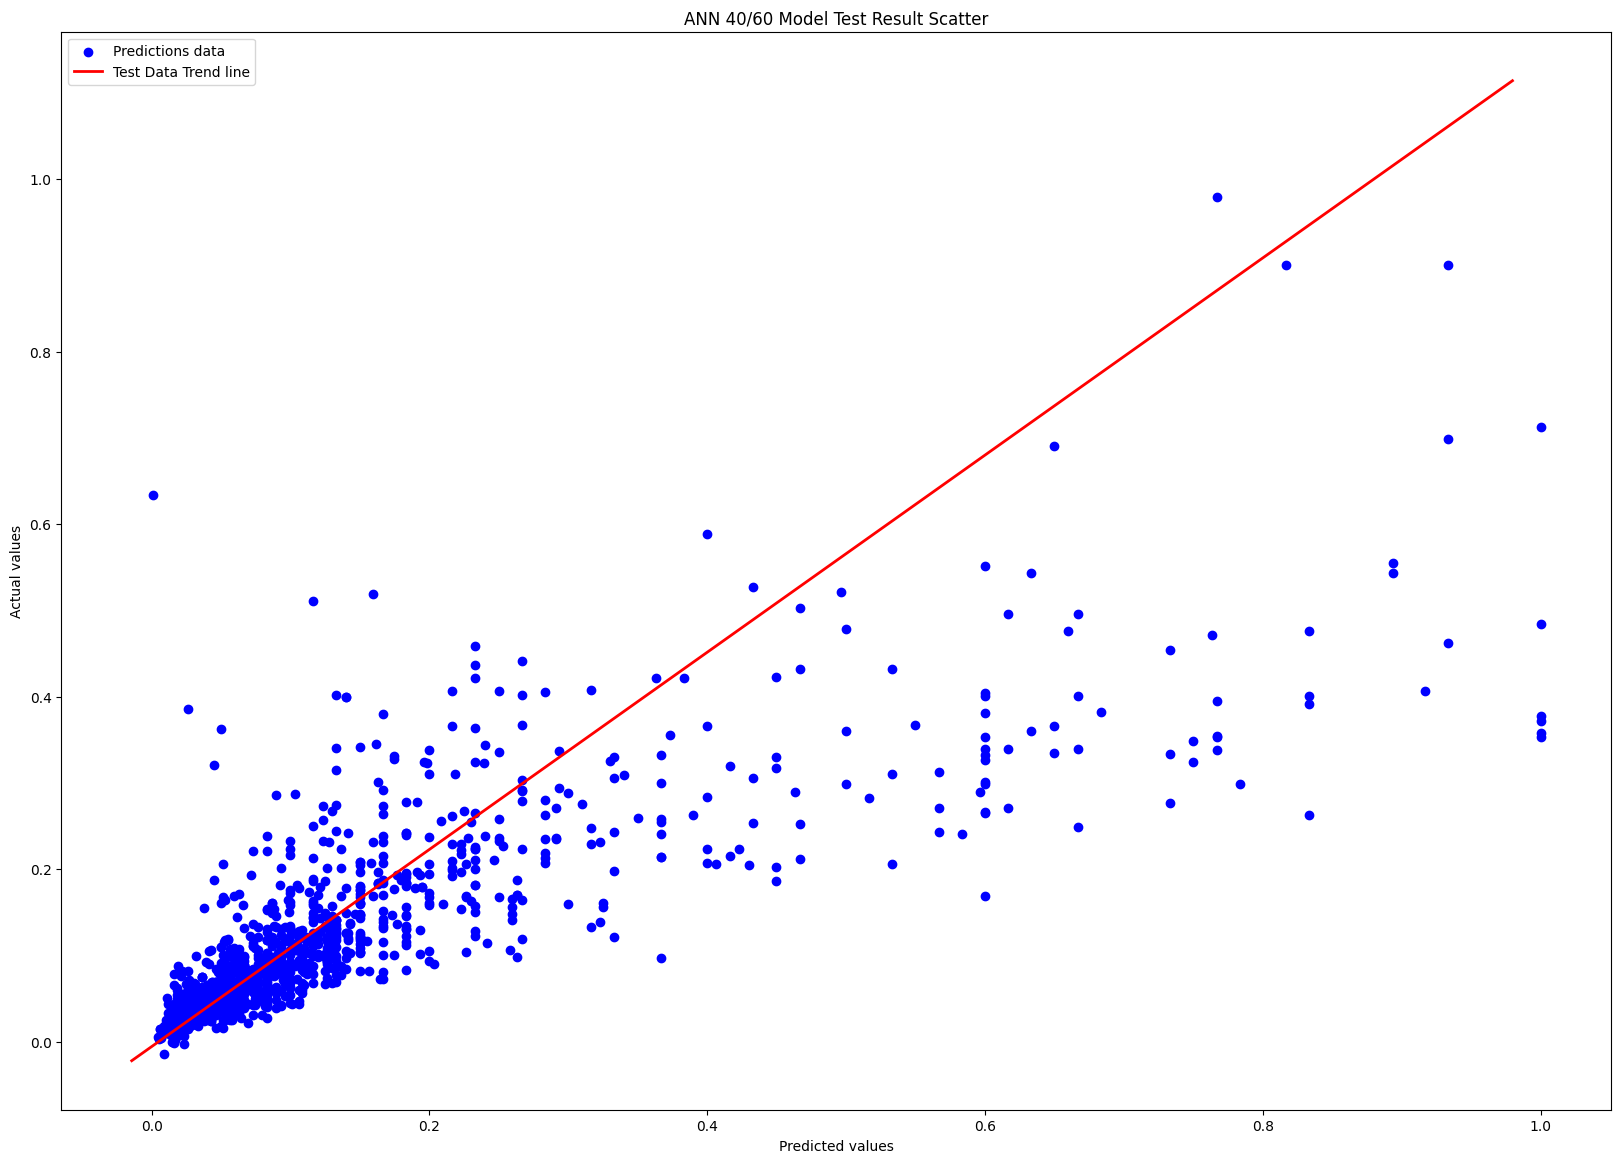

In [ ]:
plot_result(y_preds_normal_2, y_test_normal_2, title="ANN 40/60 Model Test Result Scatter")

### Test & train ratio (50/50)



In [ ]:
tf.random.set_seed(60)

house_price_model_3 = tuner.hypermodel.build(best_hps, model_name='model_50/50_ratio', dropout=True)

house_price_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.000316227766016838),
                          metrics=model_metrics)

history_normalized_3 = house_price_model_3.fit(X_train_normal_3,
                                y_train_normal_3,
                                epochs=500,
                                callbacks=[early_stopping],
                                validation_data=(X_val_normal_3, y_val_normal_3),
                                verbose=1)
history_normalized_result_3 = house_price_model_3.evaluate(X_test_normal_3, y_test_normal_3)

Epoch 1/500
103/103 [==============================] - 1s 6ms/step - loss: 0.0948 - mae: 0.0948 - mse: 0.0293 - rmse: 0.1540 - r2: 0.0954 - val_loss: 0.0798 - val_mae: 0.0798 - val_mse: 0.0229 - val_rmse: 0.1513 - val_r2: 0.0290
Epoch 2/500
103/103 [==============================] - 0s 3ms/step - loss: 0.0830 - mae: 0.0830 - mse: 0.0252 - rmse: 0.1586 - r2: 0.0270 - val_loss: 0.0747 - val_mae: 0.0747 - val_mse: 0.0210 - val_rmse: 0.1450 - val_r2: 0.1081
Epoch 3/500
103/103 [==============================] - 0s 3ms/step - loss: 0.0792 - mae: 0.0792 - mse: 0.0234 - rmse: 0.1531 - r2: 0.0939 - val_loss: 0.0721 - val_mae: 0.0721 - val_mse: 0.0198 - val_rmse: 0.1408 - val_r2: 0.1590
Epoch 4/500
103/103 [==============================] - 0s 3ms/step - loss: 0.0765 - mae: 0.0765 - mse: 0.0220 - rmse: 0.1483 - r2: 0.1495 - val_loss: 0.0714 - val_mae: 0.0714 - val_mse: 0.0182 - val_rmse: 0.1350 - val_r2: 0.2273
Epoch 5/500
103/103 [==============================] - 0s 3ms/step - loss: 0.0745 - 

In [ ]:
house_price_model_3.summary()

Model: "model_50/50_ratio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                350       
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Plot Each Metrics

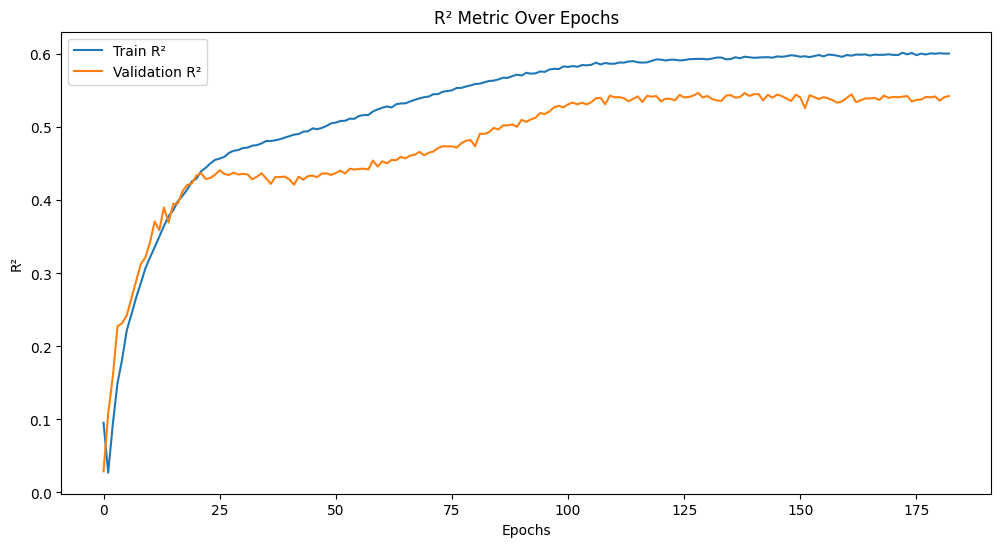

In [ ]:
history_df_3 = pd.DataFrame(history_normalized_3.history)

# Plot R²
plt.figure(figsize=(12, 6))
plt.plot(history_df_3['r2'], label='Train R²')

plt.plot(history_df_3['val_r2'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('R² Metric Over Epochs')
plt.legend()
plt.show()


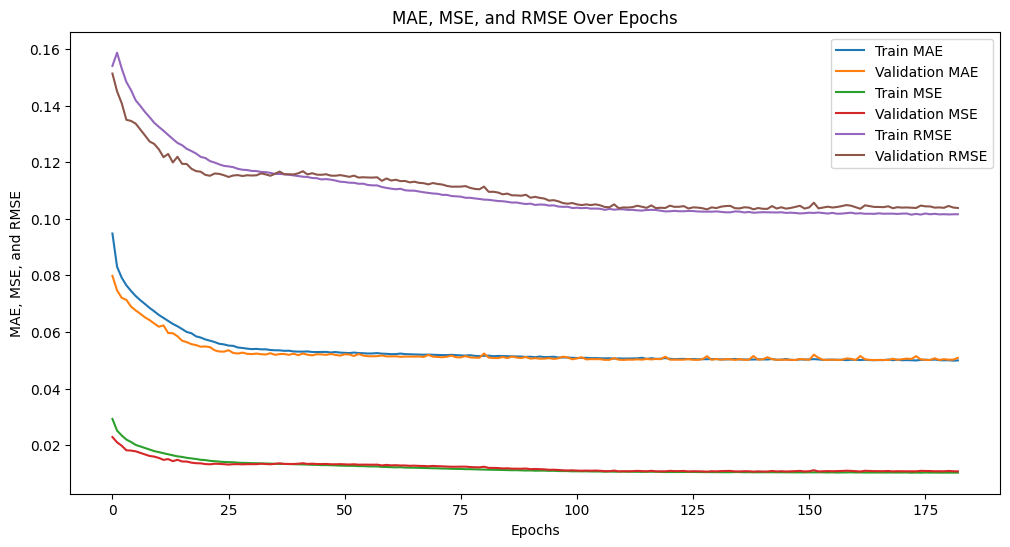

In [ ]:
# Plot MAE, MSE, and RMSE
plt.figure(figsize=(12, 6))
plt.plot(history_df_3['mae'], label='Train MAE')
plt.plot(history_df_3['val_mae'], label='Validation MAE')
plt.plot(history_df_3['mse'], label='Train MSE')
plt.plot(history_df_3['val_mse'], label='Validation MSE')
plt.plot(history_df_3['rmse'], label='Train RMSE')
plt.plot(history_df_3['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('MAE, MSE, and RMSE')
plt.title('MAE, MSE, and RMSE Over Epochs')
plt.legend()
plt.show()

<Axes: xlabel='epochs'>

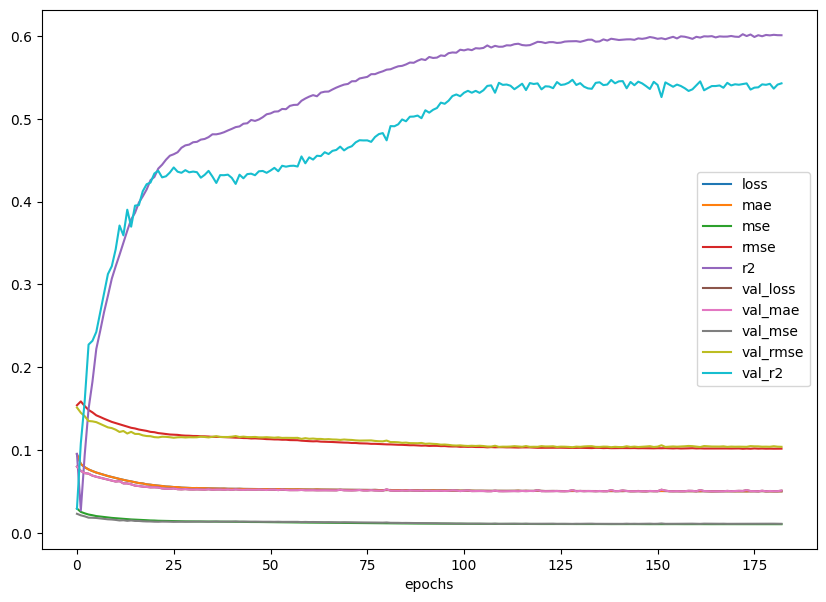

In [ ]:
pd.DataFrame(history_normalized_3.history).plot(figsize=(10, 7), xlabel="epochs")

#### Results

In [ ]:
y_preds_normal_3 = house_price_model_3.predict(X_test_normal_3.astype('float'))

52/52 [==============================] - 0s 1ms/step


In [ ]:
df_result_data_3 = {
    'y_test': y_test_normal_3.squeeze(),
    'y_preds': y_preds_normal_3.squeeze(),
    'diff': y_test_normal_3.squeeze() - y_preds_normal_3.squeeze()
}

df_result_3 = pd.DataFrame(df_result_data_3)
df_result_3.head()

,y_test,y_preds,diff
0,0.010604,0.015162,-0.004558
1,0.019608,0.019566,0.000042
2,0.139656,0.102626,0.037030
3,0.028178,0.031905,-0.003727
4,0.866613,0.908262,-0.041648


In [ ]:
y_preds_normal_3 = house_price_model_3.predict(X_test_normal_3.astype('float'))

52/52 [==============================] - 0s 1ms/step


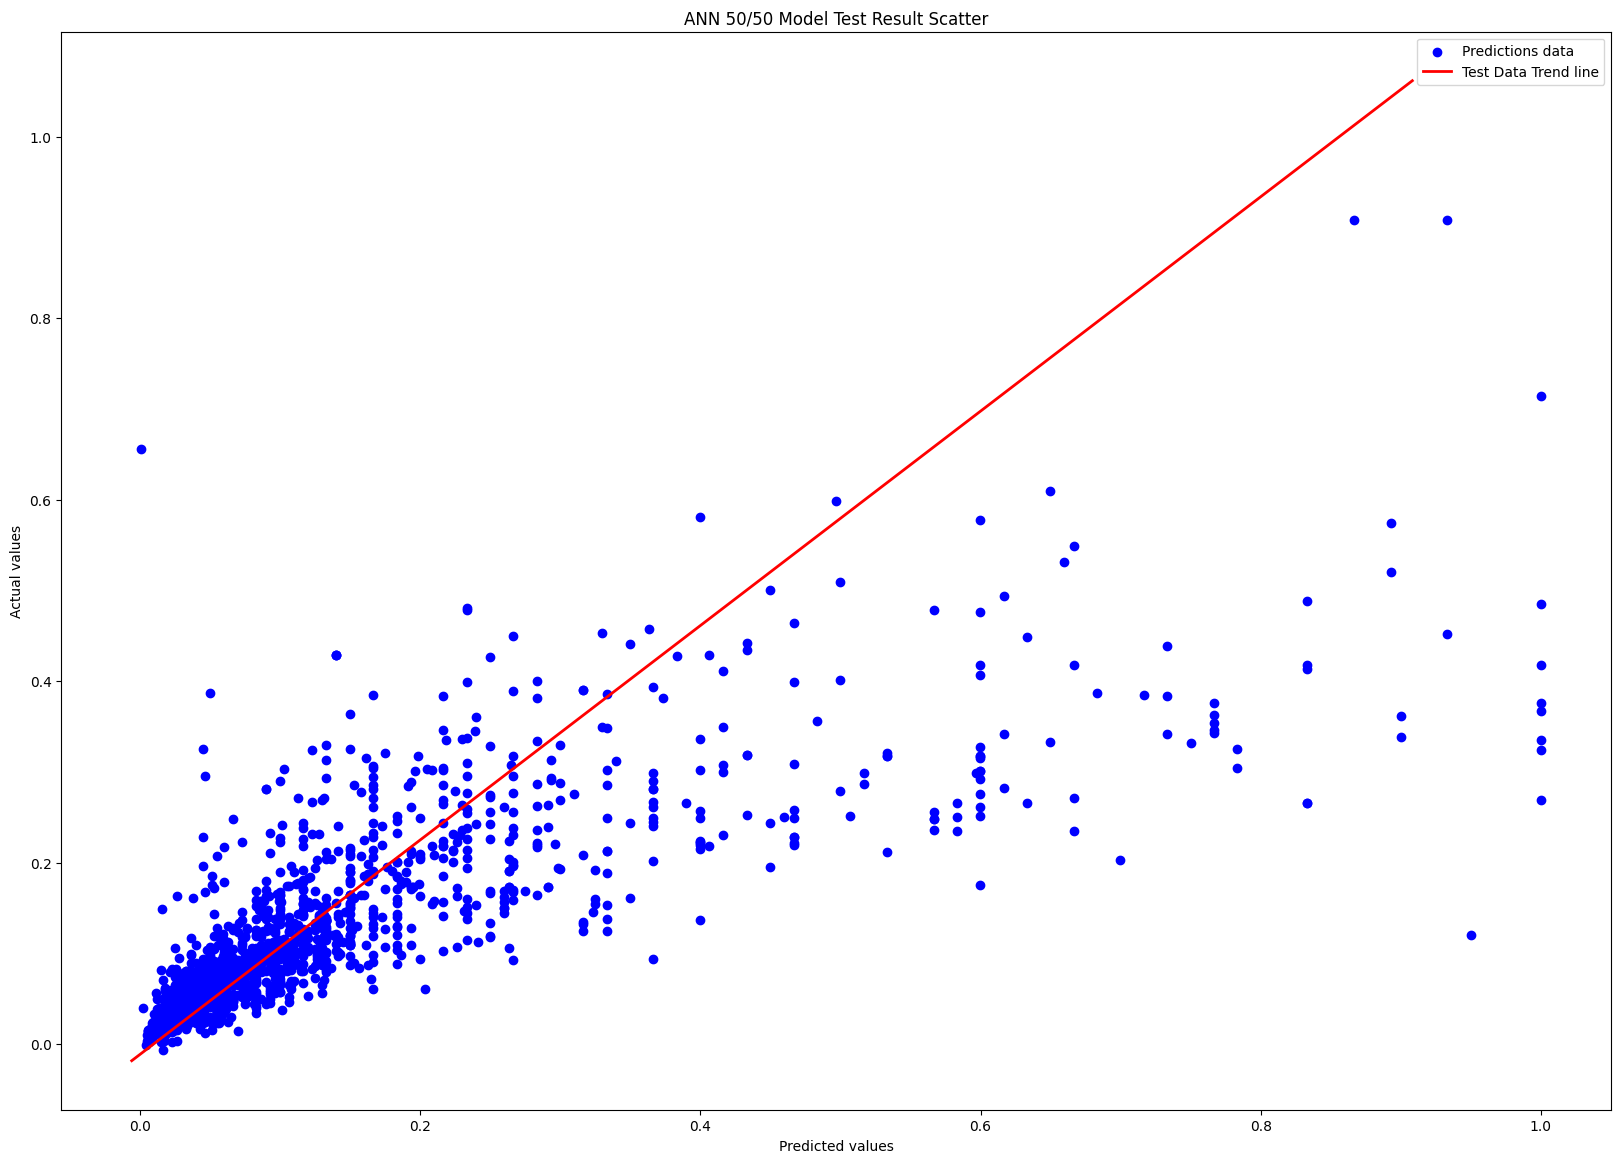

In [ ]:
plot_result(y_preds_normal_3, y_test_normal_3, title="ANN 50/50 Model Test Result Scatter")

## Random Forest Model


### Test & train ratio (20/80)

In [ ]:
# data_split_random = 60
# val_size = 0.1
estimators = 512
max_depth = 5

tf.random.set_seed(60)

# X_train_full_normal, X_val_normal, y_train_full_normal, y_val_normal = train_test_split(X_train_normal, y_train_normal, test_size=val_size, random_state=data_split_random)

rf_house_price_model = RandomForestRegressor(n_estimators=estimators,
                                             max_depth=max_depth,
                                             max_features='sqrt',
                                            #  min_samples_leaf=4,
                                            #  min_samples_split=5,
                                             oob_score=True,
                                             random_state=42)

rf_house_price_model.fit(X_train_normal, y_train_normal)

y_train_preds = rf_house_price_model.predict(X_train_normal)
y_test_preds = rf_house_price_model.predict(X_test_normal)
y_val_preds = rf_house_price_model.predict(X_val_normal)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
y_train_normal, y_train_preds

(array([[0.01627318],
        [0.06595972],
        [0.02460984],
        ...,
        [0.02210884],
        [0.06595972],
        [0.04628518]]),
 array([0.02786881, 0.16155294, 0.04121867, ..., 0.03582927, 0.12955664,
        0.06334159]))

#### Results

In [ ]:
oob_score = rf_house_price_model.oob_score_
print(f"OOB Score: {oob_score}")

OOB Score: 0.6937894918017293


In [ ]:
mae_scorer = make_scorer(mean_absolute_error)
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(rf_house_price_model, X_train_normal, y_train_normal, cv=kf, scoring=mae_scorer, verbose=1)

# Cross-validation for MSE
mse_scores = cross_val_score(rf_house_price_model, X_train_normal, y_train_normal, cv=kf, scoring=mse_scorer, verbose=1)

# Cross-validation for R2
r2_scores = cross_val_score(rf_house_price_model, X_train_normal, y_train_normal, cv=kf, scoring=r2_scorer, verbose=1)

print("\n\nCross-validated MAE: ", np.mean(mae_scores))
print("Cross-validated MSE: ", np.mean(mse_scores))
print("Cross-validated R2: ", np.mean(r2_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi



Cross-validated MAE:  0.04741731721251616
Cross-validated MSE:  0.007860653552319836
Cross-validated R2:  0.6901581074620415


In [ ]:
mae_train = mean_absolute_error(y_train_normal, y_train_preds)
mse_train = mean_squared_error(y_train_normal, y_train_preds)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_normal, y_train_preds)

print(f'Mean Absolute Error (MAE): {mae_train}')
print(f'Mean Squared Error (MSE): {mse_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_train}')
print(f'R-squared (R2): {r2_train}')

Mean Absolute Error (MAE): 0.044968855857105965
Mean Squared Error (MSE): 0.006814944095644858
Root Mean Squared Error (RMSE): 0.08255267467287089
R-squared (R2): 0.7315928447086505


In [ ]:
mae_val = mean_absolute_error(y_val_normal, y_val_preds)
mse_val = mean_squared_error(y_val_normal, y_val_preds)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val_normal, y_val_preds)

print(f'Mean Absolute Error (MAE): {mae_val}')
print(f'Mean Squared Error (MSE): {mse_val}')
print(f'Root Mean Squared Error (RMSE): {rmse_val}')
print(f'R-squared (R2): {r2_val}')

Mean Absolute Error (MAE): 0.04791600606264224
Mean Squared Error (MSE): 0.008917564326027215
Root Mean Squared Error (RMSE): 0.09443285617848914
R-squared (R2): 0.657070398053768


In [ ]:
mae_test = mean_absolute_error(y_test_normal, y_test_preds)
mse_test = mean_squared_error(y_test_normal, y_test_preds)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_normal, y_test_preds)

print(f'Mean Absolute Error (MAE): {mae_test}')
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test}')
print(f'R-squared (R2): {r2_test}')

Mean Absolute Error (MAE): 0.04801256161714913
Mean Squared Error (MSE): 0.008285029825452272
Root Mean Squared Error (RMSE): 0.09102213920498832
R-squared (R2): 0.6816843602014813


#### Plot Results and Metrics

In [ ]:
# train_results = [mae_train, mse_train, rmse_train]
# val_results = [mae_val, mse_val, rmse_val]
# metrics = ['MAE', 'MSE', 'RMSE']
# plot_stack_bar(train_results, val_results, metrics)

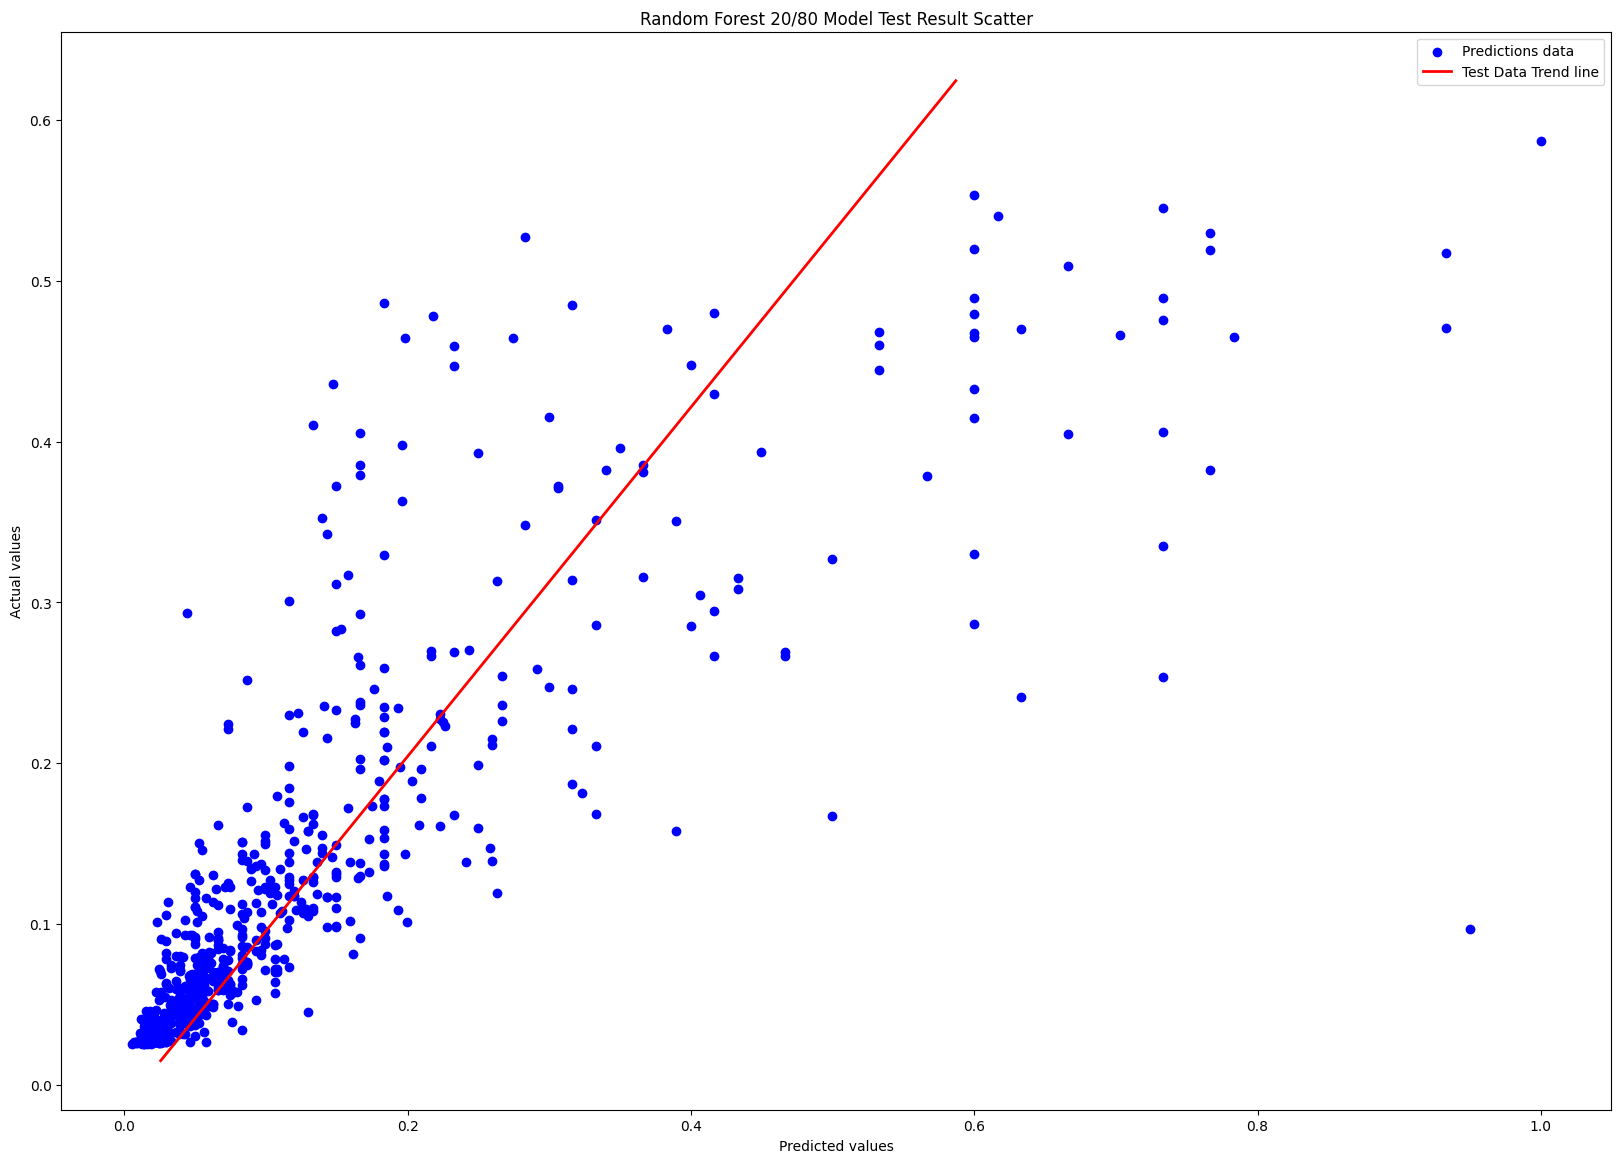

In [ ]:
plot_result(y_test_preds, y_test_normal, title="Random Forest 20/80 Model Test Result Scatter")

### Test & train ratio (30/70)

In [ ]:
rf_house_price_model_1 = RandomForestRegressor(n_estimators=estimators,
                                              max_depth=max_depth,
                                              max_features='sqrt',
                                              oob_score=True,
                                              random_state=42)

rf_house_price_model_1.fit(X_train_normal_1, y_train_normal_1)

y_train_preds_1 = rf_house_price_model_1.predict(X_train_normal_1)
y_test_preds_1 = rf_house_price_model_1.predict(X_test_normal_1)
y_val_preds_1 = rf_house_price_model_1.predict(X_val_normal_1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### Results

In [ ]:
oob_score_1 = rf_house_price_model_1.oob_score_
print(f"OOB Score: {oob_score_1}")

OOB Score: 0.6978619739136565


In [ ]:
mae_train_1 = mean_absolute_error(y_train_normal_1, y_train_preds_1)
mse_train_1 = mean_squared_error(y_train_normal_1, y_train_preds_1)
rmse_train_1 = np.sqrt(mse_train_1)
r2_train_1 = r2_score(y_train_normal_1, y_train_preds_1)

print(f'Mean Absolute Error (MAE): {mae_train_1}')
print(f'Mean Squared Error (MSE): {mse_train_1}')
print(f'Root Mean Squared Error (RMSE): {rmse_train_1}')
print(f'R-squared (R2): {r2_train_1}')

Mean Absolute Error (MAE): 0.044602382665809515
Mean Squared Error (MSE): 0.006555319098174737
Root Mean Squared Error (RMSE): 0.08096492511065972
R-squared (R2): 0.7391688842391617


In [ ]:
mae_val_1 = mean_absolute_error(y_val_normal_1, y_val_preds_1)
mse_val_1 = mean_squared_error(y_val_normal_1, y_val_preds_1)
rmse_val_1 = np.sqrt(mse_val_1)
r2_val_1 = r2_score(y_val_normal_1, y_val_preds_1)

print(f'Mean Absolute Error (MAE): {mae_val_1}')
print(f'Mean Squared Error (MSE): {mse_val_1}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_1}')
print(f'R-squared (R2): {r2_val_1}')

Mean Absolute Error (MAE): 0.04944939961312833
Mean Squared Error (MSE): 0.008804112364097285
Root Mean Squared Error (RMSE): 0.09383023161059172
R-squared (R2): 0.6637755001610028


In [ ]:
mae_test_1 = mean_absolute_error(y_test_normal_1, y_test_preds_1)
mse_test_1 = mean_squared_error(y_test_normal_1, y_test_preds_1)
rmse_test_1 = np.sqrt(mse_test_1)
r2_test_1 = r2_score(y_test_normal_1, y_test_preds_1)

print(f'Mean Absolute Error (MAE): {mae_test_1}')
print(f'Mean Squared Error (MSE): {mse_test_1}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_1}')
print(f'R-squared (R2): {r2_test_1}')

Mean Absolute Error (MAE): 0.047184733409854816
Mean Squared Error (MSE): 0.008249967316458726
Root Mean Squared Error (RMSE): 0.09082933070577326
R-squared (R2): 0.6903015869569218


#### Plot Results and Metrics

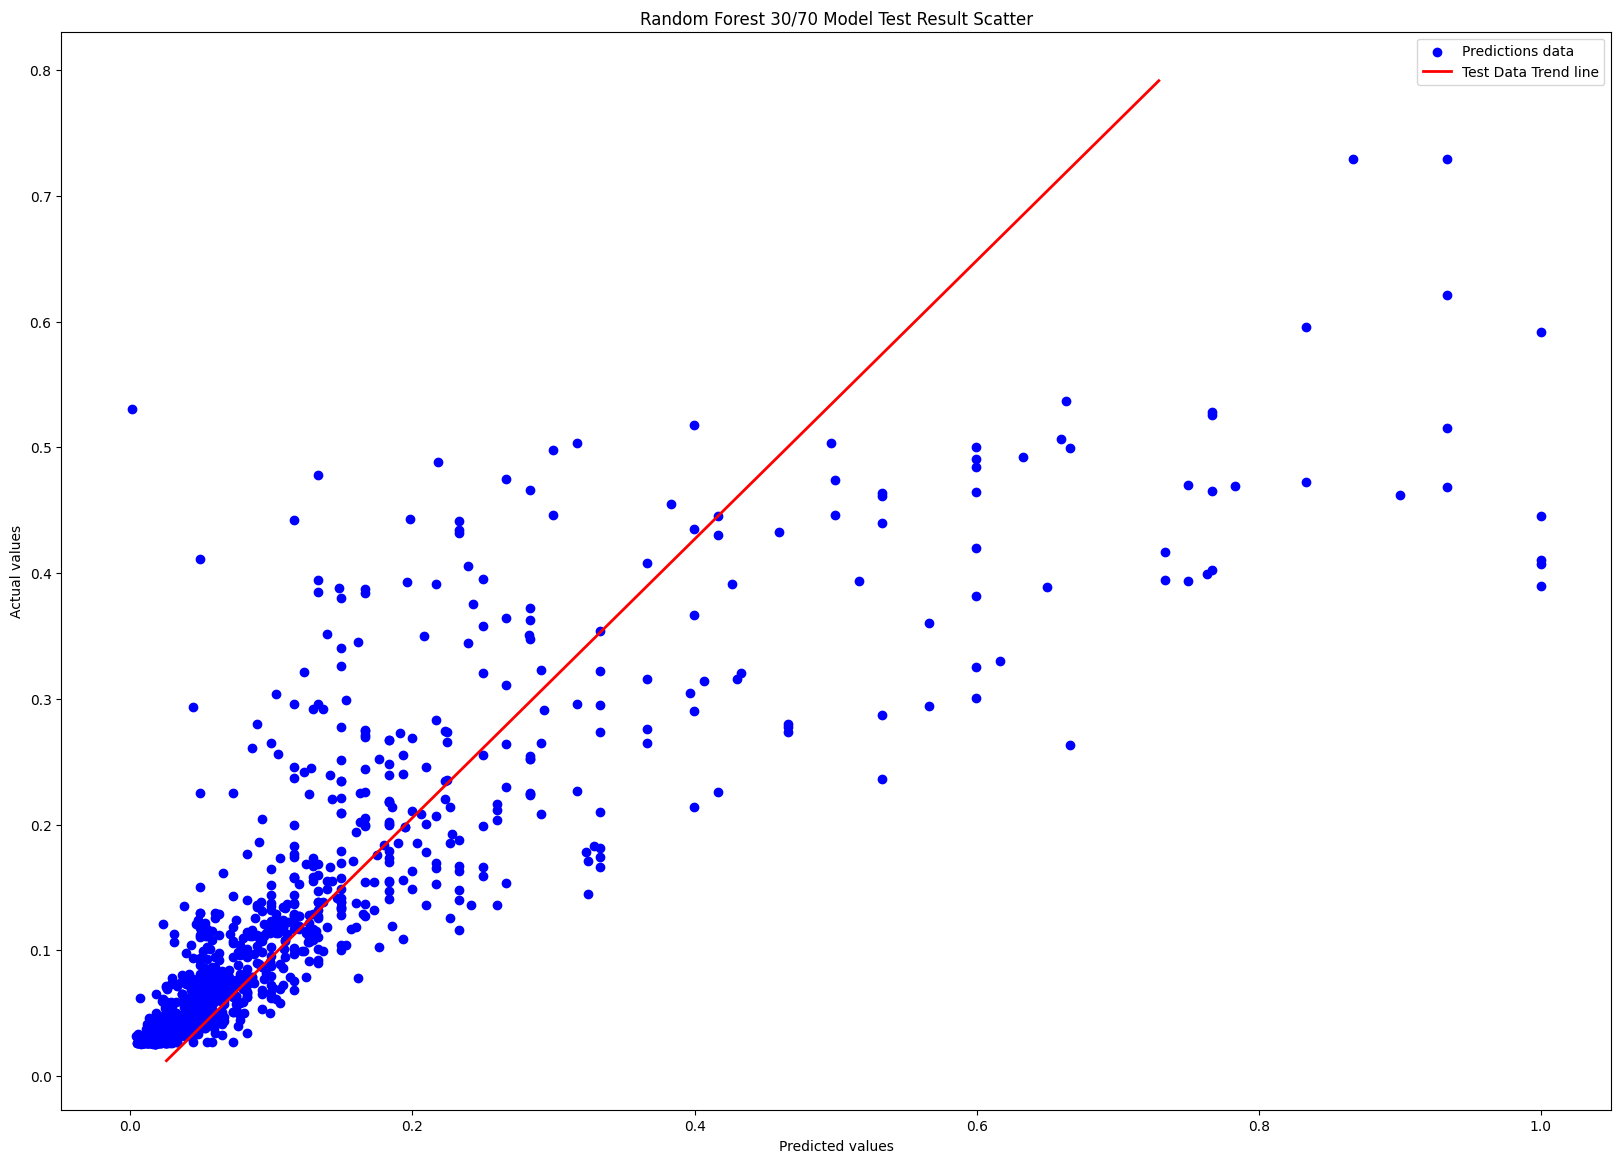

In [ ]:
plot_result(y_test_preds_1, y_test_normal_1, title="Random Forest 30/70 Model Test Result Scatter")

### Test & train ratio (40/60)

In [ ]:
rf_house_price_model_2 = RandomForestRegressor(n_estimators=estimators,
                                              max_depth=max_depth,
                                              max_features='sqrt',
                                              oob_score=True,
                                              random_state=42)

rf_house_price_model_2.fit(X_train_normal_2, y_train_normal_2)

y_train_preds_2 = rf_house_price_model_2.predict(X_train_normal_2)
y_test_preds_2 = rf_house_price_model_2.predict(X_test_normal_2)
y_val_preds_2 = rf_house_price_model_2.predict(X_val_normal_2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### Results

In [ ]:
oob_score_2 = rf_house_price_model_2.oob_score_
print(f"OOB Score: {oob_score_2}")

OOB Score: 0.6877462507692225


In [ ]:
mae_train_2 = mean_absolute_error(y_train_normal_2, y_train_preds_2)
mse_train_2 = mean_squared_error(y_train_normal_2, y_train_preds_2)
rmse_train_2 = np.sqrt(mse_train_2)
r2_train_2 = r2_score(y_train_normal_2, y_train_preds_2)

print(f'Mean Absolute Error (MAE): {mae_train_2}')
print(f'Mean Squared Error (MSE): {mse_train_2}')
print(f'Root Mean Squared Error (RMSE): {rmse_train_2}')
print(f'R-squared (R2): {r2_train_2}')

Mean Absolute Error (MAE): 0.044905527311444614
Mean Squared Error (MSE): 0.006652939127996914
Root Mean Squared Error (RMSE): 0.08156555111072882
R-squared (R2): 0.7388461322817063


In [ ]:
mae_val_2 = mean_absolute_error(y_val_normal_2, y_val_preds_2)
mse_val_2 = mean_squared_error(y_val_normal_2, y_val_preds_2)
rmse_val_2 = np.sqrt(mse_val_2)
r2_val_2 = r2_score(y_val_normal_2, y_val_preds_2)

print(f'Mean Absolute Error (MAE): {mae_val_2}')
print(f'Mean Squared Error (MSE): {mse_val_2}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_2}')
print(f'R-squared (R2): {r2_val_2}')

Mean Absolute Error (MAE): 0.0477925511328866
Mean Squared Error (MSE): 0.007783446675069235
Root Mean Squared Error (RMSE): 0.08822384414130477
R-squared (R2): 0.6765602513698922


In [ ]:
mae_test_2 = mean_absolute_error(y_test_normal_2, y_test_preds_2)
mse_test_2 = mean_squared_error(y_test_normal_2, y_test_preds_2)
rmse_test_2 = np.sqrt(mse_test_2)
r2_test_2 = r2_score(y_test_normal_2, y_test_preds_2)

print(f'Mean Absolute Error (MAE): {mae_test_2}')
print(f'Mean Squared Error (MSE): {mse_test_2}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_2}')
print(f'R-squared (R2): {r2_test_2}')

Mean Absolute Error (MAE): 0.04703178470063795
Mean Squared Error (MSE): 0.007893362911953326
Root Mean Squared Error (RMSE): 0.08884459979060813
R-squared (R2): 0.7085093262177147


#### Plot Result and Metrics

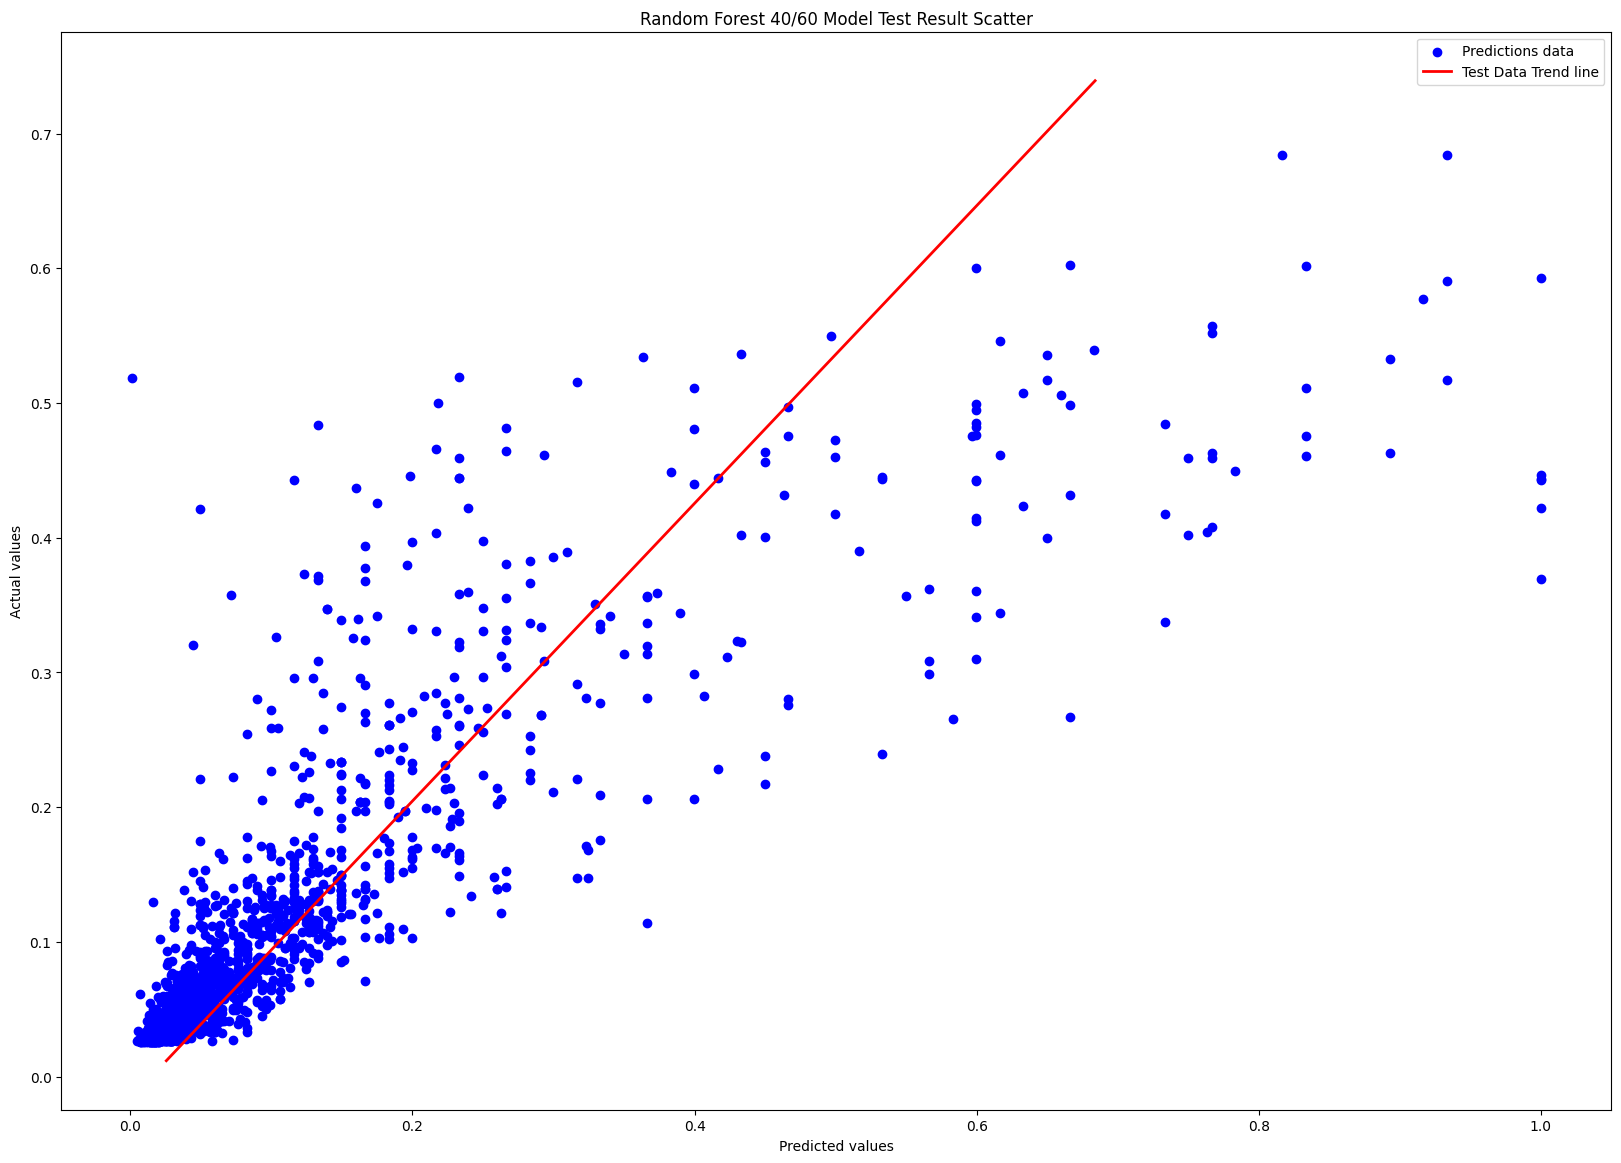

In [ ]:
plot_result(y_test_preds_2, y_test_normal_2, title="Random Forest 40/60 Model Test Result Scatter")

### Test & train ratio (50/50)



In [ ]:
rf_house_price_model_3 = RandomForestRegressor(n_estimators=estimators,
                                              max_depth=max_depth,
                                              max_features='sqrt',
                                              oob_score=True,
                                              random_state=42)

rf_house_price_model_3.fit(X_train_normal_3, y_train_normal_3)

y_train_preds_3 = rf_house_price_model_3.predict(X_train_normal_3)
y_test_preds_3 = rf_house_price_model_3.predict(X_test_normal_3)
y_val_preds_3 = rf_house_price_model_3.predict(X_val_normal_3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### Results

In [ ]:
oob_score_3 = rf_house_price_model_3.oob_score_
print(f"OOB Score: {oob_score_3}")

OOB Score: 0.6894392060885365


In [ ]:
mae_train_3 = mean_absolute_error(y_train_normal_3, y_train_preds_3)
mse_train_3 = mean_squared_error(y_train_normal_3, y_train_preds_3)
rmse_train_3 = np.sqrt(mse_train_3)
r2_train_3 = r2_score(y_train_normal_3, y_train_preds_3)

print(f'Mean Absolute Error (MAE): {mae_train_3}')
print(f'Mean Squared Error (MSE): {mse_train_3}')
print(f'Root Mean Squared Error (RMSE): {rmse_train_3}')
print(f'R-squared (R2): {r2_train_3}')

Mean Absolute Error (MAE): 0.04453937028628712
Mean Squared Error (MSE): 0.006499770326515084
Root Mean Squared Error (RMSE): 0.08062115309591573
R-squared (R2): 0.7487141592216366


In [ ]:
mae_val_3 = mean_absolute_error(y_val_normal_3, y_val_preds_3)
mse_val_3 = mean_squared_error(y_val_normal_3, y_val_preds_3)
rmse_val_3 = np.sqrt(mse_val_3)
r2_val_3 = r2_score(y_val_normal_3, y_val_preds_3)

print(f'Mean Absolute Error (MAE): {mae_val_3}')
print(f'Mean Squared Error (MSE): {mse_val_3}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_3}')
print(f'R-squared (R2): {r2_val_3}')

Mean Absolute Error (MAE): 0.046795199869241605
Mean Squared Error (MSE): 0.007210304570501012
Root Mean Squared Error (RMSE): 0.08491351229634193
R-squared (R2): 0.6940934290113223


In [ ]:
mae_test_3 = mean_absolute_error(y_test_normal_3, y_test_preds_3)
mse_test_3 = mean_squared_error(y_test_normal_3, y_test_preds_3)
rmse_test_3 = np.sqrt(mse_test_3)
r2_test_3 = r2_score(y_test_normal_3, y_test_preds_3)

print(f'Mean Absolute Error (MAE): {mae_test_3}')
print(f'Mean Squared Error (MSE): {mse_test_3}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_3}')
print(f'R-squared (R2): {r2_test_3}')

Mean Absolute Error (MAE): 0.048417316734791445
Mean Squared Error (MSE): 0.008460052357025977
Root Mean Squared Error (RMSE): 0.09197854291641056
R-squared (R2): 0.6835892341327957


#### Plot Results and Metrics

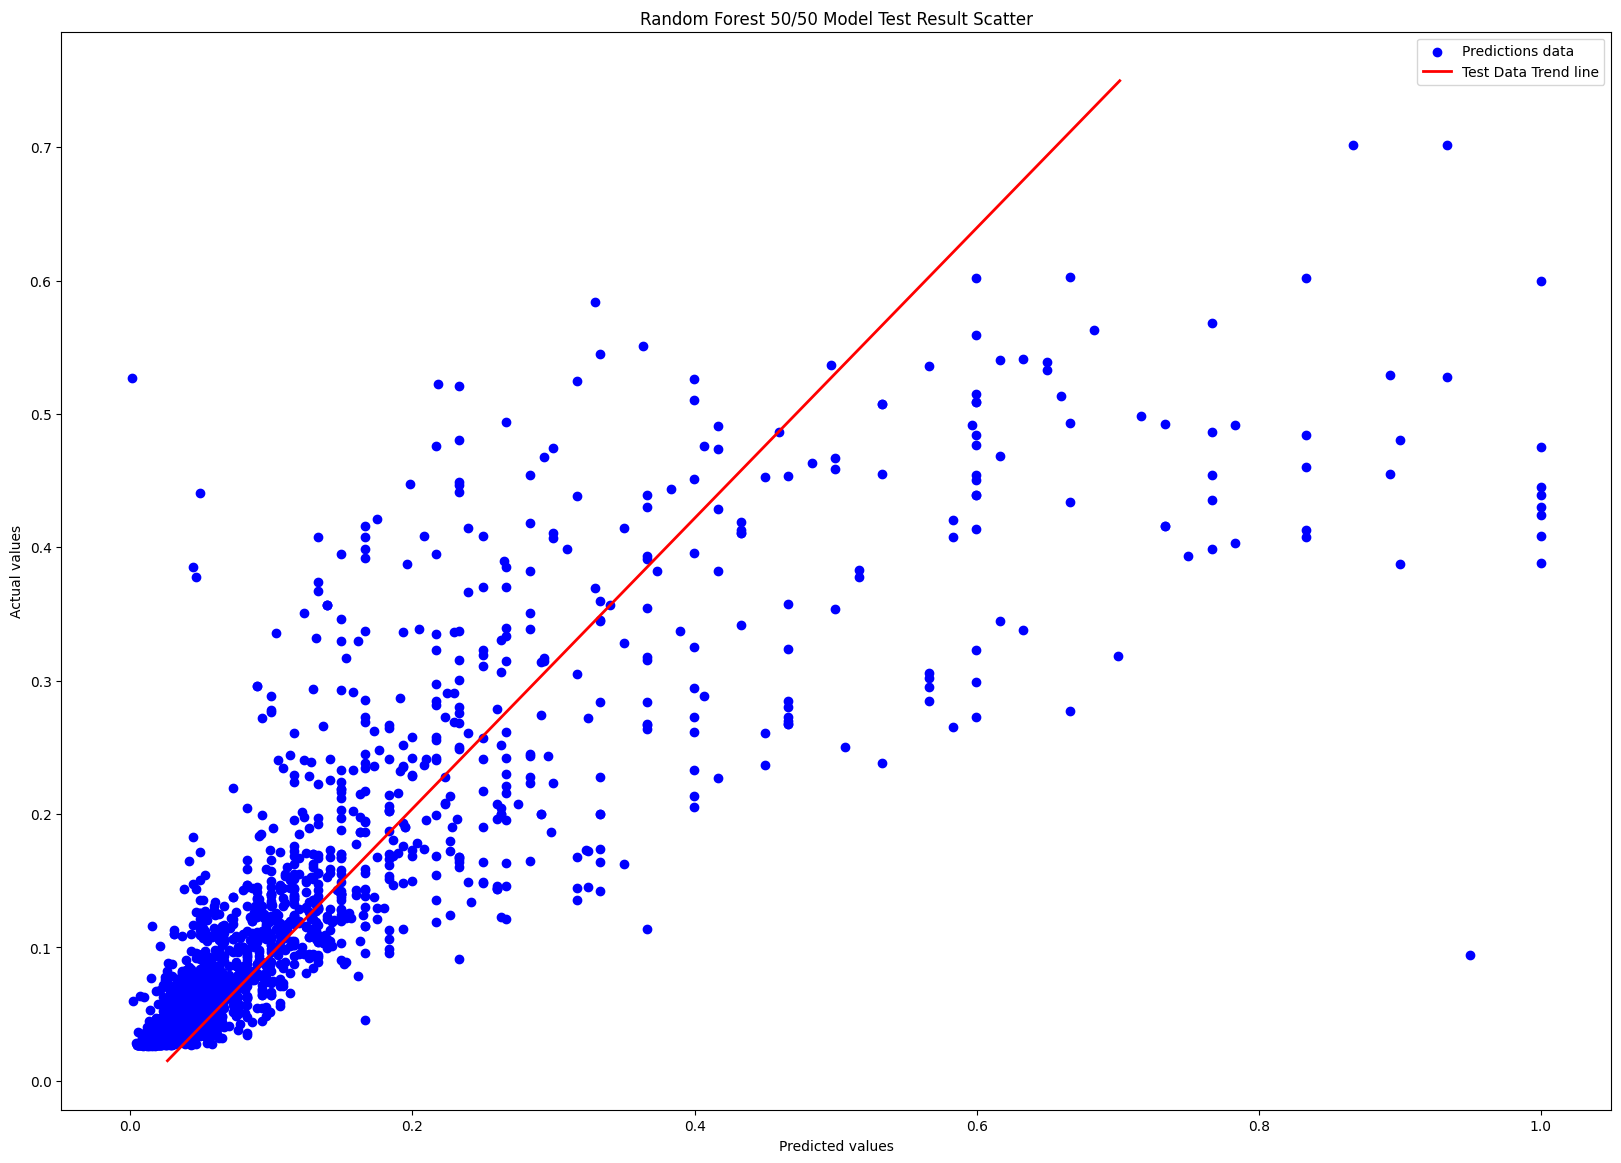

In [ ]:
plot_result(y_test_preds_3, y_test_normal_3, title="Random Forest 50/50 Model Test Result Scatter")

## Save Model

In [ ]:
import pickle

with open('model_rf_best.pkl','wb') as f:
    pickle.dump(rf_house_price_model_2,f)